# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [43]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 90)



# magic word for producing visualizations in notebook
%matplotlib inline


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("./AZDIAS_Feature_Summary.csv", sep=";")
feat_info.set_index('attribute', inplace=True)

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
for df in [azdias, feat_info]:
    display(df.head())
    print(df.shape)
    print(df.dtypes)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


(891221, 85)
AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


(85, 3)
information_level     object
type                  object
missing_or_unknown    object
dtype: object


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# First Pass at Replacing strings with literal evaluations
# on just a few rows
for i, column in enumerate(azdias.columns):
    if i%5 == 4: # Evaluate every fifth line 
        print(column)
        nan_codes = feat_info.loc[column]['missing_or_unknown']
        print(f"{nan_codes} is type {type(nan_codes)}")
        nan_codes = nan_codes.replace('XX', "'XX'")
        nan_codes = nan_codes.replace('X', "'X'")
        nan_codes_list = ast.literal_eval(nan_codes)
        print(f"{nan_codes_list} is type {type(nan_codes_list)}")

FINANZ_MINIMALIST
[-1] is type <class 'str'>
[-1] is type <class 'list'>
FINANZ_HAUSBAUER
[-1] is type <class 'str'>
[-1] is type <class 'list'>
HEALTH_TYP
[-1,0] is type <class 'str'>
[-1, 0] is type <class 'list'>
LP_STATUS_FEIN
[0] is type <class 'str'>
[0] is type <class 'list'>
SEMIO_SOZ
[-1,9] is type <class 'str'>
[-1, 9] is type <class 'list'>
SEMIO_LUST
[-1,9] is type <class 'str'>
[-1, 9] is type <class 'list'>
SEMIO_DOM
[-1,9] is type <class 'str'>
[-1, 9] is type <class 'list'>
SOHO_KZ
[-1] is type <class 'str'>
[-1] is type <class 'list'>
ANZ_PERSONEN
[] is type <class 'str'>
[] is type <class 'list'>
WOHNDAUER_2008
[-1,0] is type <class 'str'>
[-1, 0] is type <class 'list'>
MIN_GEBAEUDEJAHR
[0] is type <class 'str'>
[0] is type <class 'list'>
CAMEO_INTL_2015
[-1,XX] is type <class 'str'>


SyntaxError: invalid syntax (<unknown>, line 1)

In [5]:
# Final evaluation of converting strings to literals
for i, column in enumerate(azdias.columns):
    print(column)
    nan_codes = feat_info.loc[column]['missing_or_unknown']
    print(f"{nan_codes} is type {type(nan_codes)}")
    try:
        nan_codes = nan_codes.replace('XX', "'XX'")
        nan_codes_list = ast.literal_eval(nan_codes)
    except (ValueError, SyntaxError) as e:
        print(f"Error: {e}")
        nan_codes = nan_codes.replace('X', "'X'")
        nan_codes_list = ast.literal_eval(nan_codes)
    print(f"{nan_codes_list} is type {type(nan_codes_list)}")

AGER_TYP
[-1,0] is type <class 'str'>
[-1, 0] is type <class 'list'>
ALTERSKATEGORIE_GROB
[-1,0,9] is type <class 'str'>
[-1, 0, 9] is type <class 'list'>
ANREDE_KZ
[-1,0] is type <class 'str'>
[-1, 0] is type <class 'list'>
CJT_GESAMTTYP
[0] is type <class 'str'>
[0] is type <class 'list'>
FINANZ_MINIMALIST
[-1] is type <class 'str'>
[-1] is type <class 'list'>
FINANZ_SPARER
[-1] is type <class 'str'>
[-1] is type <class 'list'>
FINANZ_VORSORGER
[-1] is type <class 'str'>
[-1] is type <class 'list'>
FINANZ_ANLEGER
[-1] is type <class 'str'>
[-1] is type <class 'list'>
FINANZ_UNAUFFAELLIGER
[-1] is type <class 'str'>
[-1] is type <class 'list'>
FINANZ_HAUSBAUER
[-1] is type <class 'str'>
[-1] is type <class 'list'>
FINANZTYP
[-1] is type <class 'str'>
[-1] is type <class 'list'>
GEBURTSJAHR
[0] is type <class 'str'>
[0] is type <class 'list'>
GFK_URLAUBERTYP
[] is type <class 'str'>
[] is type <class 'list'>
GREEN_AVANTGARDE
[] is type <class 'str'>
[] is type <class 'list'>
HEALTH_TYP

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for i, column in enumerate(azdias.columns):
    nan_codes = feat_info.loc[column]['missing_or_unknown']
    try:
        nan_codes = nan_codes.replace('XX', "'XX'")
        nan_codes_list = ast.literal_eval(nan_codes)
    except (ValueError, SyntaxError) as e:
        print(f"Error: {e} for {nan_codes} will replace with \'X\'")
        nan_codes = nan_codes.replace('X', "'X'")
        nan_codes_list = ast.literal_eval(nan_codes)

    azdias[column].replace(nan_codes_list, np.nan, inplace=True)
    

Error: malformed node or string: <ast.Name object at 0x7efbeed02c40> for [-1,X] will replace with 'X'


In [10]:
# Spot check to see if conversion worked.
print(f"azidas df head:")
display(azdias.head())
print(f"azidas df random:")
display(azdias.sample(n=5))

azidas df head:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


azidas df random:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
249952,NaN,4.0,1,2.0,3,2,5,1,2,4,5,NaN,7.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,6,6,3,1,7,7,7,4,1,3,3,3,4,1,3.0,0.0,NaN,1.0,3,NaN,1.0,0.0,5.0,NaN,6.0,9.0,5.0,0.0,1.0,4.0,1992.0,W,3.0,8,8C,54,0.0,0.0,3.0,0.0,3.0,2.0,3.0,6.0,5.0,4.0,3.0,2.0,1.0,5.0,444.0,3.0,1.0,2.0,1.0,1.0,3.0,3.0,4.0,6.0,3.0
168360,NaN,2.0,1,3.0,2,4,1,2,4,2,4,1979.0,12.0,0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,3.0,7,7,6,7,6,6,3,7,5,1,4,1,5,5,3.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,4.0,9.0,33.0,0.0,8.0,4.0,1997.0,O,5.0,5,5A,31,0.0,0.0,0.0,2.0,5.0,1.0,2.0,5.0,4.0,5.0,1.0,1.0,2.0,2.0,1004.0,1.0,2.0,3.0,2.0,4.0,5.0,3.0,4.0,9.0,3.0
201067,2.0,4.0,2,4.0,2,1,5,1,1,5,6,1958.0,11.0,0,2.0,32.0,10.0,11.0,5.0,4.0,2.0,1.0,8.0,4.0,1,1,1,3,4,7,7,1,3,5,6,5,2,3,3.0,0.0,NaN,2.0,4,13.0,1.0,0.0,5.0,3.0,4.0,9.0,4.0,0.0,1.0,5.0,1994.0,O,7.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,5.0,7.0,1.0,8.0,5.0,1.0,4.0,4.0,1.0,186.0,2.0,1.0,0.0,0.0,1.0,2.0,3.0,5.0,1.0,3.0
781350,NaN,3.0,1,4.0,3,4,3,5,5,3,4,NaN,12.0,0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888650,NaN,3.0,1,4.0,5,3,1,3,4,1,3,1981.0,11.0,1,3.0,35.0,11.0,10.0,5.0,10.0,5.0,1.0,15.0,1.0,4,5,4,4,5,4,4,6,2,3,5,2,4,2,2.0,0.0,NaN,2.0,2,18.0,3.0,0.0,3.0,3.0,2.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,2.0,4,4A,22,3.0,1.0,0.0,0.0,1.0,5.0,6.0,2.0,6.0,5.0,3.0,5.0,4.0,6.0,502.0,4.0,1.0,0.0,0.0,1.0,3.0,4.0,3.0,4.0,3.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isna().mean().sort_values()


ZABEOTYP                 0.000000
SEMIO_TRADV              0.000000
SEMIO_PFLICHT            0.000000
SEMIO_KAEM               0.000000
SEMIO_DOM                0.000000
SEMIO_KRIT               0.000000
SEMIO_RAT                0.000000
SEMIO_KULT               0.000000
SEMIO_ERL                0.000000
SEMIO_LUST               0.000000
SEMIO_VERT               0.000000
SEMIO_MAT                0.000000
SEMIO_REL                0.000000
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
FINANZ_VORSORGER         0.000000
ANREDE_KZ                0.000000
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
GREEN_AVANTGARDE         0.000000
FINANZTYP                0.000000
ALTERSKATEGORIE_GROB     0.003233
GFK_URLAUBERTYP          0.005446
LP_STATUS_GROB           0.005446
LP_STATUS_FEIN           0.005446
ONLINE_AFFINITAET        0.005446
RETOURTYP_BK_S

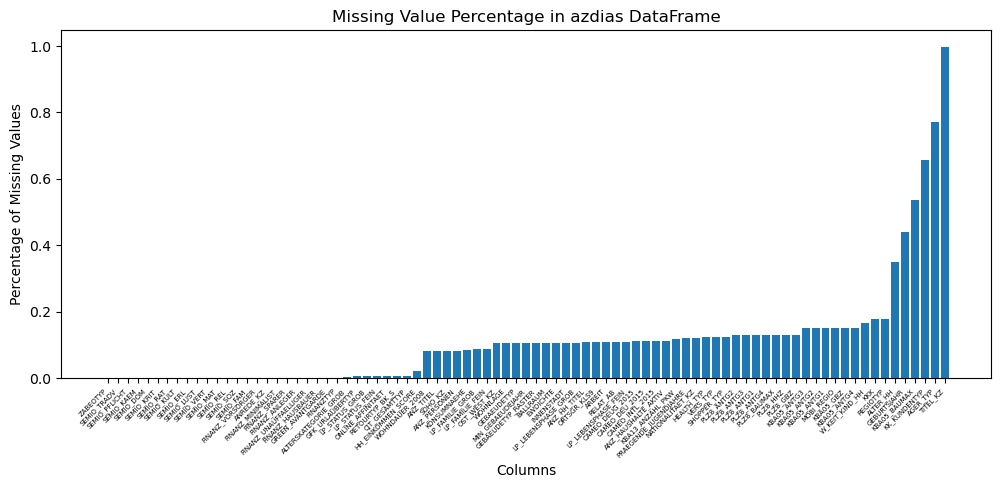

In [12]:
nan_percentages = azdias.isna().mean().sort_values()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(nan_percentages.index, nan_percentages.values)
plt.xticks(rotation=45)

# Customizing the x-axis ticks and labels
plt.xticks(range(len(nan_percentages.index)), nan_percentages.index, fontsize=5, ha='right')

plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Value Percentage in azdias DataFrame')

# Add more space to the bottom of the plot
plt.subplots_adjust(bottom=0.3)

plt.show()

# Investigate patterns in the amount of missing data in each column.
The following
2.1 ALTER_HH 0.348137: Birthdate of head of household
1.7 GEBURTSJAHR 0.440203: Year of birth
5.5 KBA05_BAUMAX 0.534687: Most common building type within the microcell
2.5 KK_KUNDENTYP 0.655967: Consumer pattern over past 12 months
1.1 AGER_TYP 0.769554: Best-ager typology
1.23 TITEL_KZ 0.997576: Academic title flag


2: Household-level features (2)
1: Person-level features (3)
5: RR3 micro-cell features

The RR3 micro-cell features quantify the utility of the buildings for a particular cell. Specifically, the feature KBA05_BAUMAX 0.534687: Most common building type within the microcell has Over 50% are NAN. We can speculate that those particular data were difficult to ascertain or collect.

The three presonal-level features
- 1.1 AGER_TYP 0.769554: Best-ager typology
- 1.23 TITEL_KZ 0.997576: Academic title flag
- 1.7 GEBURTSJAHR 0.440203: Year of birth


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

OUTLIER_COLS = ['ALTER_HH', 'GEBURTSJAHR','KBA05_BAUMAX',
            'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']

azdias_no_out = azdias.copy() 
azdias_no_out.drop(columns=OUTLIER_COLS, inplace=True)

print(f"azidas shape: {azdias.shape}")
print(f"azidas_no_out shape: {azdias_no_out.shape}")

azidas shape: (891221, 85)
azidas_no_out shape: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?

nan_row_count = azdias_no_out.isna().sum(axis=1)
azdias_no_out['NANS_P_ROW'] = nan_row_count
row_groups = azdias_no_out.groupby('NANS_P_ROW').size()
print(row_groups)

NANS_P_ROW
0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64


In [15]:
# Perform sanity check for rows with a specific NANS count (0)
rows_with_0_nans = azdias_no_out[azdias_no_out['NANS_P_ROW'] == 0]
rows_with_0_nans.sample(n=5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NANS_P_ROW
302420,3.0,1,5.0,3,3,3,1,2,4,5,8.0,1,3.0,17.0,5.0,2.0,2.0,7.0,3.0,1.0,13.0,5.0,6,6,4,4,7,6,4,5,2,3,5,3,3,4,1.0,0.0,2.0,4,3.0,1.0,4.0,2.0,4.0,4.0,1.0,8.0,1.0,1992.0,O,3.0,5,5D,34,1.0,3.0,0.0,0.0,3.0,1.0,6.0,2.0,2.0,1.0,3.0,5.0,3.0,198.0,1.0,4.0,3.0,2.0,5.0,3.0,2.0,4.0,8.0,4.0,0
81260,3.0,2,4.0,4,2,4,3,2,2,6,5.0,0,3.0,11.0,3.0,1.0,1.0,9.0,4.0,1.0,8.0,5.0,2,2,3,2,2,4,6,3,4,7,7,5,4,2,2.0,0.0,1.0,3,1.0,0.0,5.0,6.0,8.0,3.0,0.0,1.0,5.0,1992.0,W,3.0,4,4C,24,4.0,1.0,0.0,0.0,3.0,7.0,3.0,5.0,4.0,3.0,4.0,1.0,4.0,1500.0,4.0,2.0,0.0,0.0,1.0,5.0,5.0,2.0,4.0,1.0,0
526855,4.0,2,2.0,4,1,5,3,1,4,6,9.0,0,2.0,38.0,12.0,10.0,5.0,9.0,4.0,1.0,5.0,3.0,4,2,2,3,5,7,7,1,3,6,4,5,2,1,1.0,0.0,2.0,3,2.0,0.0,3.0,4.0,9.0,1.0,0.0,1.0,4.0,1992.0,O,7.0,3,3D,25,3.0,0.0,0.0,0.0,5.0,6.0,1.0,8.0,5.0,4.0,4.0,2.0,5.0,842.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,1.0,0
426914,3.0,2,4.0,1,4,1,5,5,4,4,3.0,0,2.0,24.0,7.0,6.0,4.0,2.0,1.0,1.0,14.0,4.0,1,1,1,2,2,1,6,3,4,4,6,7,4,2,3.0,0.0,1.0,3,2.0,0.0,5.0,1.0,7.0,18.0,0.0,3.0,4.0,1994.0,W,3.0,8,8C,54,0.0,0.0,0.0,2.0,1.0,2.0,5.0,5.0,3.0,3.0,1.0,4.0,5.0,575.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,2.0,4.0,3.0,0
20774,1.0,2,3.0,1,5,3,5,5,5,1,5.0,0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,1.0,1,2,4,4,1,1,2,3,6,6,7,6,6,6,2.0,0.0,1.0,4,1.0,0.0,6.0,6.0,9.0,6.0,0.0,8.0,2.0,1992.0,W,3.0,8,8C,54,0.0,0.0,2.0,1.0,2.0,1.0,6.0,4.0,4.0,2.0,1.0,2.0,3.0,429.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,9.0,4.0,0


In [16]:
# Perform sanity check for rows with a specific NANS count (9)
rows_with_9_nans = azdias_no_out[azdias_no_out['NANS_P_ROW'] == 9]
rows_with_9_nans.sample(n=5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NANS_P_ROW
735267,3.0,1,2.0,5,2,3,3,2,1,6,5.0,0,3.0,11.0,3.0,1.0,1.0,9.0,4.0,1.0,10.0,3.0,6,6,4,6,5,4,4,5,5,5,5,3,5,4,1.0,0.0,2.0,2,1.0,0.0,3.0,3.0,9.0,1.0,0.0,1.0,5.0,1994.0,W,8.0,2,2D,14,2.0,1.0,0.0,0.0,5.0,6.0,2.0,8.0,4.0,NaN,4.0,4.0,NaN,547.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,9
121434,3.0,2,5.0,1,4,3,5,5,3,1,7.0,0,NaN,NaN,NaN,1.0,1.0,5.0,2.0,NaN,NaN,2.0,1,4,4,4,4,4,7,4,4,7,4,4,4,4,NaN,0.0,NaN,6,1.0,0.0,2.0,6.0,9.0,2.0,0.0,1.0,5.0,1997.0,W,7.0,7,7B,41,4.0,1.0,0.0,0.0,3.0,7.0,1.0,8.0,3.0,NaN,5.0,3.0,NaN,633.0,3.0,1.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,5.0,9
819672,1.0,2,3.0,2,4,1,5,4,3,1,2.0,0,3.0,26.0,8.0,7.0,4.0,6.0,3.0,1.0,14.0,2.0,2,4,5,4,1,2,4,3,6,7,6,4,5,6,3.0,0.0,2.0,2,2.0,0.0,2.0,1.0,9.0,1.0,0.0,3.0,5.0,1997.0,O,8.0,2,2D,14,NaN,NaN,NaN,NaN,NaN,7.0,2.0,5.0,2.0,NaN,NaN,5.0,NaN,NaN,3.0,1.0,0.0,0.0,1.0,3.0,4.0,3.0,2.0,1.0,9
840729,3.0,2,2.0,4,2,4,4,3,1,3,12.0,0,2.0,4.0,1.0,1.0,1.0,4.0,2.0,1.0,10.0,4.0,4,1,1,2,4,1,6,1,4,7,6,5,4,3,3.0,0.0,1.0,6,0.0,0.0,3.0,NaN,8.0,2.0,0.0,1.0,5.0,2005.0,W,8.0,3,3A,23,NaN,NaN,NaN,NaN,NaN,7.0,2.0,4.0,5.0,NaN,NaN,2.0,NaN,560.0,3.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,9
714390,4.0,2,1.0,4,1,5,4,4,2,2,11.0,0,3.0,12.0,3.0,1.0,1.0,9.0,4.0,1.0,NaN,3.0,2,3,4,4,4,4,7,1,4,7,4,5,4,4,1.0,0.0,1.0,3,1.0,0.0,3.0,6.0,9.0,2.0,0.0,1.0,4.0,2005.0,W,8.0,2,2A,12,NaN,NaN,NaN,NaN,NaN,6.0,2.0,7.0,4.0,NaN,NaN,2.0,NaN,2300.0,3.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,1.0,9


In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# This code block was ran a few times to settle on a threshold (THD) value.
# 8 NANs was chosen as this allows for ~87% of the data to be analyzed
# For comparison
# - THD = 0 -> ~70%
# - THD = 1 -> ~72%
# - THD = 7 -> ~84%
# - THD = 8 -> ~87% <-
# - THD = 9 -> ~87%
# - THD = 10 -> ~88%
# - THD = 20 -> ~89%
THD = 8 # (THD) THRESHOLD
azdias_no_out_less_than_THD = azdias_no_out[azdias_no_out['NANS_P_ROW'] <= THD]
azdias_no_out_great_than_THD = azdias_no_out[azdias_no_out['NANS_P_ROW'] > THD]

# Drop the 'NaN_Count' column if not needed
azdias_no_out_less_than_THD.drop('NANS_P_ROW', axis=1, inplace=True)
azdias_no_out_great_than_THD.drop('NANS_P_ROW', axis=1, inplace=True)

# Print the resulting DataFrames
TDR = azdias_no_out.shape[0]

print("Total Dataframe:")
print(azdias_no_out.shape)

TDR_lte_THD = azdias_no_out_less_than_THD.shape[0]
print(f"Dataframe with less than or equal to {THD} NaN:")
print(f"Shape: {azdias_no_out_less_than_THD.shape}, Percent: {np.round(TDR_lte_THD*100/TDR, 2)}")

TDR_gt_THD = azdias_no_out_great_than_THD.shape[0]
print(f"\nDataframe with more than {THD} NaN:")
print(azdias_no_out_great_than_THD.shape)
print(f"Shape: {azdias_no_out_great_than_THD.shape}, Percent: {np.round(TDR_gt_THD*100/TDR, 2)}")


Total Dataframe:
(891221, 80)
Dataframe with less than or equal to 8 NaN:
Shape: (771701, 79), Percent: 86.59

Dataframe with more than 8 NaN:
(119520, 79)
Shape: (119520, 79), Percent: 13.41


<ipython-input-17-986e32f37de6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_no_out_less_than_THD.drop('NANS_P_ROW', axis=1, inplace=True)
<ipython-input-17-986e32f37de6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_no_out_great_than_THD.drop('NANS_P_ROW', axis=1, inplace=True)


In [18]:
# We will randomly choose rows from both df subsets:
# - azdias_no_out_less_than_THD
# - azdias_no_out_great_than_THD
# in order to select the columns for distribution plots.

display(azdias_no_out_less_than_THD.sample(n=10))
display(azdias_no_out_great_than_THD.sample(n=10))

# From the analysis, we chose the following columns:
SUBSET_COLS = ['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',	
 'CJT_GESAMTTYP',	
'FINANZ_MINIMALIST',	
'FINANZ_SPARER',	
'FINANZ_VORSORGER',	
'FINANZ_ANLEGER',	
'FINANZ_UNAUFFAELLIGER',	
'FINANZ_HAUSBAUER',	
'FINANZTYP',	
'GFK_URLAUBERTYP',	
'GREEN_AVANTGARDE',
'LP_STATUS_FEIN',	
'LP_STATUS_GROB',
'ONLINE_AFFINITAET',
'HH_EINKOMMEN_SCORE',
'ZABEOTYP',
'RETOURTYP_BK_S',	
'SEMIO_SOZ',	
'SEMIO_FAM',	
'SEMIO_REL',	
'SEMIO_MAT',	
'SEMIO_VERT',	
'SEMIO_LUST',	
'SEMIO_ERL',	
'SEMIO_KULT',	
'SEMIO_RAT',	
'SEMIO_KRIT',	
'SEMIO_DOM',	
'SEMIO_KAEM',	
'SEMIO_PFLICHT',	
'SEMIO_TRADV']

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
307702,3.0,1,3.0,5,1,5,2,1,2,6,10.0,0,3.0,37.0,12.0,10.0,5.0,9.0,4.0,1.0,8.0,4.0,6,4,4,1,5,4,4,6,2,1,5,3,5,4,0.0,0.0,2.0,1,4.0,0.0,4.0,2.0,9.0,2.0,0.0,1.0,4.0,1992.0,W,7.0,3,3D,25,3.0,2.0,0.0,0.0,4.0,6.0,1.0,5.0,5.0,4.0,4.0,5.0,5.0,783.0,4.0,2.0,1.0,0.0,1.0,3.0,4.0,2.0,2.0,2.0
283601,3.0,1,2.0,4,2,4,3,3,2,2,5.0,0,3.0,11.0,3.0,1.0,1.0,9.0,4.0,1.0,8.0,3.0,6,4,4,1,5,1,4,5,2,5,2,3,4,2,1.0,0.0,2.0,3,1.0,0.0,3.0,5.0,9.0,3.0,0.0,1.0,5.0,1992.0,W,3.0,3,3A,23,4.0,0.0,0.0,0.0,4.0,6.0,3.0,8.0,5.0,3.0,4.0,1.0,6.0,342.0,2.0,2.0,0.0,0.0,1.0,2.0,3.0,3.0,5.0,2.0
329712,2.0,1,2.0,3,2,4,1,3,2,5,10.0,1,3.0,32.0,10.0,9.0,5.0,3.0,2.0,1.0,11.0,3.0,7,7,6,3,7,2,3,7,5,5,4,1,6,5,0.0,0.0,2.0,4,2.0,0.0,4.0,4.0,9.0,10.0,0.0,1.0,4.0,1992.0,W,2.0,7,7A,41,0.0,0.0,1.0,1.0,3.0,1.0,5.0,4.0,4.0,2.0,2.0,2.0,2.0,827.0,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
594182,1.0,1,4.0,1,5,3,4,5,5,1,9.0,0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,1.0,7,7,7,3,6,2,1,7,4,4,1,2,7,5,1.0,0.0,2.0,4,1.0,0.0,6.0,6.0,9.0,22.0,0.0,3.0,4.0,1992.0,W,3.0,8,8C,54,0.0,0.0,0.0,2.0,1.0,1.0,5.0,4.0,2.0,3.0,1.0,3.0,6.0,499.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,3.0,8.0,5.0
620552,4.0,2,2.0,3,1,5,2,2,5,2,11.0,0,2.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,5.0,3.0,2,1,2,3,2,7,7,1,2,7,4,5,2,1,1.0,0.0,2.0,3,1.0,0.0,5.0,6.0,3.0,8.0,0.0,1.0,1.0,1992.0,W,7.0,7,7B,41,2.0,2.0,0.0,0.0,4.0,5.0,3.0,4.0,3.0,4.0,6.0,1.0,7.0,604.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0
406109,3.0,1,1.0,3,3,3,4,2,3,6,5.0,0,3.0,7.0,2.0,1.0,1.0,4.0,2.0,1.0,8.0,5.0,3,2,4,4,5,6,4,5,2,5,2,3,1,4,2.0,0.0,2.0,6,1.0,0.0,6.0,5.0,9.0,31.0,0.0,3.0,7.0,1994.0,O,7.0,9,9C,51,0.0,0.0,0.0,2.0,1.0,6.0,1.0,5.0,1.0,4.0,1.0,0.0,6.0,238.0,3.0,2.0,1.0,0.0,1.0,2.0,2.0,4.0,1.0,4.0
411326,4.0,1,4.0,3,1,5,1,2,5,5,4.0,0,1.0,15.0,4.0,2.0,2.0,1.0,1.0,1.0,8.0,5.0,3,6,5,6,7,7,3,4,1,3,3,1,4,4,3.0,0.0,1.0,6,2.0,0.0,5.0,4.0,9.0,10.0,0.0,8.0,3.0,1992.0,W,4.0,6,6E,45,0.0,0.0,2.0,1.0,2.0,4.0,6.0,2.0,3.0,2.0,1.0,1.0,2.0,595.0,2.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,6.0,3.0
469070,3.0,2,1.0,5,1,4,2,1,3,2,9.0,0,2.0,19.0,5.0,2.0,2.0,9.0,4.0,1.0,5.0,5.0,2,1,1,2,4,1,6,1,4,7,6,5,4,3,3.0,0.0,1.0,2,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,3.0,2000.0,O,8.0,2,2D,14,NaN,NaN,NaN,NaN,NaN,5.0,1.0,5.0,4.0,NaN,NaN,4.0,NaN,814.0,2.0,3.0,1.0,1.0,1.0,4.0,4.0,3.0,4.0,1.0
116225,1.0,1,4.0,4,4,1,3,3,1,3,12.0,0,1.0,10.0,3.0,1.0,1.0,9.0,4.0,1.0,14.0,3.0,7,7,7,5,6,2,1,7,5,2,2,2,7,5,0.0,0.0,2.0,5,1.0,0.0,5.0,4.0,9.0,2.0,0.0,1.0,4.0,1992.0,W,3.0,4,4D,24,3.0,1.0,0.0,0.0,4.0,1.0,6.0,4.0,4.0,4.0,4.0,3.0,5.0,357.0,3.0,1.0,1.0,0.0,1.0,3.0,4.0,4.0,9.0,3.0
298497,1.0,1,3.0,1,5,2,5,4,5,1,4.0,0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,4.0,7,7,7,5,6,3,1,7,4,2,1,2,7,5,0.0,0.0,1.0,4,1.0,0.0,4.0,6.0,9.0,27.0,2.0,3.0,1.0,1992.0,O,5.0,5,5D,34,0.0,0.0,0.0,2.0,1.0,1.0,6.0,2.0,2.0,3.0,1.0,3.0,6.0,216.0,1.0,0.0,2.0,2.0,4.0,4.0,2.0,4.0,9.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
526214,1.0,1,1.0,3,4,3,5,5,3,4,8.0,0,NaN,20.0,5.0,2.0,2.0,10.0,5.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90889,2.0,2,4.0,3,4,3,5,5,3,4,7.0,0,NaN,34.0,11.0,10.0,5.0,9.0,4.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741332,1.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252149,1.0,1,1.0,3,4,3,5,5,3,4,11.0,0,NaN,11.0,3.0,1.0,1.0,9.0,4.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368418,1.0,1,2.0,3,4,3,5,5,3,4,3.0,0,NaN,40.0,12.0,10.0,5.0,10.0,5.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192337,1.0,1,3.0,3,4,3,5,5,3,4,7.0,0,NaN,20.0,5.0,2.0,2.0,10.0,5.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
679546,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
554133,4.0,2,1.0,4,2,4,4,3,1,6,10.0,0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,4.0,2,1,4,4,4,5,7,1,4,7,6,6,4,1,1.0,0.0,1.0,3,1.0,0.0,NaN,NaN,7.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
850818,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785391,1.0,1,1.0,3,4,3,5,5,3,4,10.0,0,NaN,12.0,3.0,1.0,1.0,9.0,4.0,NaN,NaN,4.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


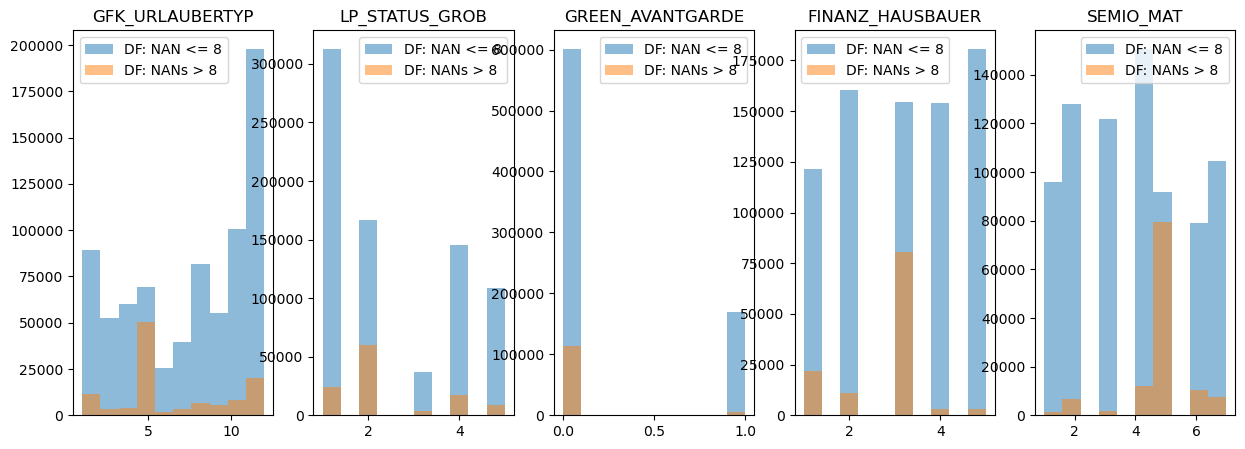

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Columns to plot
# Choose sequentially
# COLS_TO_PLOT = SUBSET_COLS[2:7]

# Columns to plot
# Choose randomly
COLS_TO_PLOT = random.sample(SUBSET_COLS, 5)

# Create a figure with subplots
fig, axs = plt.subplots(1, len(COLS_TO_PLOT), figsize=(15, 5))

# Plot the distribution of each column for DF having rows with NANs <= THD
for i, col in enumerate(COLS_TO_PLOT):
    axs[i].hist(azdias_no_out_less_than_THD[col], 
                bins=10, alpha=0.5, label=f"DF: NAN <= {THD}")
    axs[i].set_title(col)
    axs[i].legend()

# Plot the distribution of each column for DF having rows with NANs > THD
for i, col in enumerate(COLS_TO_PLOT):
    axs[i].hist(azdias_no_out_great_than_THD[col], 
                bins=10, alpha=0.5, label=f"DF: NANs > {THD}")
    axs[i].legend()

# Show the plot
plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

There is an evident difference in distributions for most of the sampled columns with little to no NAN values between the two subset dataframes. The most notable qualitative difference are the spikes in a single-value for the NAN > THD subset dataframe. This spike occurs for different values depending on column.
As the threshold is increased from 0 to 8, the spikes become more pronounced. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?

#display(azdias_no_out_less_than_THD.head())
#display(feat_info.head())

categorical_count = 0
ordinal_count = 0 
numeric_count = 0
mixed_count = 0
interval_count = 0

CATEGORICAL_COLS = []
ORDINAL_COLS = []
NUMERIC_COLS = []
MIXED_COLS = []
INTERVAL_COLS = []

for col in azdias_no_out_less_than_THD.columns:
    DATA_TYPE = feat_info.loc[col]['type']

    if DATA_TYPE == 'categorical':
        categorical_count += 1
        CATEGORICAL_COLS.append(col)
    if DATA_TYPE == 'ordinal':
        ordinal_count += 1
        ORDINAL_COLS.append(col)
    if DATA_TYPE == 'numeric':
        numeric_count += 1
        NUMERIC_COLS.append(col)
    if DATA_TYPE == 'mixed':
        mixed_count += 1
        MIXED_COLS.append(col)
    if DATA_TYPE == 'interval':
        interval_count += 1
        INTERVAL_COLS.append(col)
        
print(f"categorical_count: {categorical_count}")
print(f"ordinal_count: {ordinal_count}")
print(f"numeric_count: {numeric_count}")
print(f"mixed_count: {mixed_count}")
print(f"interval_count: {interval_count}")

    

categorical_count: 18
ordinal_count: 49
numeric_count: 6
mixed_count: 6
interval_count: 0


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

for col in CATEGORICAL_COLS:
    unique_values = azdias_no_out_less_than_THD[col].unique()
    length = len(azdias_no_out_less_than_THD[col].unique())
    print(f"Column {col} has {unique_values}, length {length}")
    #print(f"Column {col} has length {length}")



Column ANREDE_KZ has [2 1], length 2
Column CJT_GESAMTTYP has [5. 3. 2. 4. 1. 6.], length 6
Column FINANZTYP has [1 6 5 2 4 3], length 6
Column GFK_URLAUBERTYP has [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6.], length 12
Column GREEN_AVANTGARDE has [0 1], length 2
Column LP_FAMILIE_FEIN has [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.], length 12
Column LP_FAMILIE_GROB has [ 3.  1. nan  5.  2.  4.], length 6
Column LP_STATUS_FEIN has [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.], length 10
Column LP_STATUS_GROB has [1. 2. 4. 5. 3.], length 5
Column NATIONALITAET_KZ has [ 1.  3.  2. nan], length 4
Column SHOPPER_TYP has [ 3.  2.  1.  0. nan], length 5
Column SOHO_KZ has [1. 0.], length 2
Column VERS_TYP has [ 2.  1. nan], length 3
Column ZABEOTYP has [5 3 4 1 6 2], length 6
Column GEBAEUDETYP has [8. 1. 3. 2. 6. 4. 5.], length 7
Column OST_WEST_KZ has ['W' 'O'], length 2
Column CAMEO_DEUG_2015 has ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan], length 10
Column CAMEO_DEU_2015 has ['8A' '

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Input:
#      df [No NAN Column Outliers, 
#          Rows with less than 8 (THD) NANs]
# Output:
#      df [No NANs Column Outliers,
#          Rows with less than 8 (THD) NANs
#          Processed Categorical Columns]


azdias_noout_ltTHD_catp = azdias_no_out_less_than_THD.copy()
CATEGORICAL_CATP_COLS = []
categorical_catp_count = 0
# Cardinality Threshold for consideration
CTH  = 5

## Drop columns with cardinality >= 5
for col in CATEGORICAL_COLS:
    unique_values = azdias_noout_ltTHD_catp[col].unique()
    length = len(azdias_noout_ltTHD_catp[col].unique())
    if length >= CTH:
        azdias_noout_ltTHD_catp.drop(col, axis=1, inplace=True)
    else:
        CATEGORICAL_CATP_COLS.append(col)
        categorical_catp_count += 1


print("Drop columns with cardinality >= 5")
print(f"categorical_count: {categorical_count}")
print(f"categorical_catp_count: {categorical_catp_count}")

print(f"azdias_no_out_less_than_THD (ANOLTTHD): {azdias_no_out_less_than_THD.shape}")
print(f"azdias_noout_ltTHD_catp (ANLC): {azdias_noout_ltTHD_catp.shape}")
print(f"(ANOLTTHD)['OST_WEST_KZ'].unique() : {azdias_no_out_less_than_THD['OST_WEST_KZ'].unique()}")
print(f"(ANLC)['OST_WEST_KZ'].unique(): {azdias_noout_ltTHD_catp['OST_WEST_KZ'].unique()}")
print("")

## Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]
# Define a mapping dictionary for the conversion
mapping = {'W': 0, 'O': 1}
# Use the map() function to convert the values
azdias_noout_ltTHD_catp['OST_WEST_KZ'] =\
    azdias_noout_ltTHD_catp['OST_WEST_KZ'].map(mapping)



print("Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]")
print(f"categorical_count: {categorical_count}")
print(f"categorical_catp_count: {categorical_catp_count}")

print(f"azdias_no_out_less_than_THD (ANOLTTHD): {azdias_no_out_less_than_THD.shape}")
print(f"azdias_noout_ltTHD_catp (ANLC): {azdias_noout_ltTHD_catp.shape}")
print(f"(ANOLTTHD)['OST_WEST_KZ'].unique() : {azdias_no_out_less_than_THD['OST_WEST_KZ'].unique()}")
print(f"(ANLC)['OST_WEST_KZ'].unique(): {azdias_noout_ltTHD_catp['OST_WEST_KZ'].unique()}")
print("")

CATEGORICAL_CATP_COLS_TMP = []
CATEGORICAL_REMOVE = []
## One-Hot-Encoding of categorial variables with cardinality >= 3
for col in CATEGORICAL_CATP_COLS:
    try: 
        unique_values = azdias_noout_ltTHD_catp[col].unique()
        length = len(azdias_noout_ltTHD_catp[col].unique())
        if length >= 3:
            original_cols = azdias_noout_ltTHD_catp.columns
            
            azdias_noout_ltTHD_catp = pd.get_dummies(azdias_noout_ltTHD_catp, columns=[col])
            # Save the one-hot encoded column for later removal
            CATEGORICAL_REMOVE.append(col)
            # Get the names of the newly created one-hot encoded columns 
            new_cols = set(azdias_noout_ltTHD_catp.columns) - set(original_cols)
            # Add the newly created one-hot encoded to tmp list to be later added
            CATEGORICAL_CATP_COLS_TMP.extend(new_cols)
            # Drop original categorical variables which were one-hot-encoded
            azdias_noout_ltTHD_catp.drop(col, axis=1, inplace=True)
        else:
            print(f"Skipping {col}. Cardinality: {length}")
            
    except KeyError:
        print(f"The column {col} does not exist.")


CATEGORICAL_CATP_COLSx = [x for x in CATEGORICAL_CATP_COLS if x not in CATEGORICAL_REMOVE]
CATEGORICAL_CATP_COLS= CATEGORICAL_CATP_COLSx
CATEGORICAL_CATP_COLS.extend(CATEGORICAL_CATP_COLS_TMP)
categorical_catp_count = len(CATEGORICAL_CATP_COLS)



print("One-Hot-Encoding of categorial variables with cardinality >= 3, < 5")
print(f"categorical_count: {categorical_count}")
print(f"categorical_catp_count: {categorical_catp_count}")

print(f"azdias_no_out_less_than_THD (ANOLTTHD): {azdias_no_out_less_than_THD.shape}")
print(f"azdias_noout_ltTHD_catp (ANLC): {azdias_noout_ltTHD_catp.shape}")
print(f"(ANOLTTHD)['OST_WEST_KZ'].unique() : {azdias_no_out_less_than_THD['OST_WEST_KZ'].unique()}")
print(f"(ANLC)['OST_WEST_KZ'].unique(): {azdias_noout_ltTHD_catp['OST_WEST_KZ'].unique()}")
print("")

display(azdias_no_out_less_than_THD.head())
display(azdias_noout_ltTHD_catp.head())


Drop columns with cardinality >= 5
categorical_count: 18
categorical_catp_count: 6
azdias_no_out_less_than_THD (ANOLTTHD): (771701, 79)
azdias_noout_ltTHD_catp (ANLC): (771701, 67)
(ANOLTTHD)['OST_WEST_KZ'].unique() : ['W' 'O']
(ANLC)['OST_WEST_KZ'].unique(): ['W' 'O']

Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]
categorical_count: 18
categorical_catp_count: 6
azdias_no_out_less_than_THD (ANOLTTHD): (771701, 79)
azdias_noout_ltTHD_catp (ANLC): (771701, 67)
(ANOLTTHD)['OST_WEST_KZ'].unique() : ['W' 'O']
(ANLC)['OST_WEST_KZ'].unique(): [0 1]

Skipping ANREDE_KZ. Cardinality: 2
Skipping GREEN_AVANTGARDE. Cardinality: 2
The column NATIONALITAET_KZ does not exist.
Skipping SOHO_KZ. Cardinality: 2
The column VERS_TYP does not exist.
Skipping OST_WEST_KZ. Cardinality: 2
One-Hot-Encoding of categorial variables with cardinality >= 3, < 5
categorical_count: 18
categorical_catp_count: 9
azdias_no_out_less_than_THD (ANOLTTHD): (771701, 79)
azdias_noout_ltTHD_catp (ANLC): (7717

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,0,0,1
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,0,0,1,0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,0,1,0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,1
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# Re-encode mixed variable(s) to be kept in the analysis.
# Input:
#      df [No NAN Column Outliers, 
#          Rows with less than 8 (THD) NANs,
#          Processed Categorical Columns (catp)]
# Output:
#      df [No NANs Column Outliers,
#          Rows with less than 8 (THD) NANs
#          Processed Categorical Columns (catp)
#          Processed Mixed Columns (mixp)]

azdias_noout_ltTHD_catp_mixp = azdias_noout_ltTHD_catp.copy()

In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# PRAEGENDE_JUGENDJAHRE_GEN
# 1 -> 40 <- if 1 or 2
# 2 -> 50 <- if 3 or 4
# 3 -> 60 <- if 5, 6 or 7
# 4 -> 70 <- if 8, 9
# 5 -> 80 <- if 10, 11, 12, 13
# 6 -> 90 <- if 14, 15
# nan
# PRAEGENDE_JUGENDJAHRE_MOVE
# 0 -> avantgarde if 2, 4, 6, 7, 9, 11, 13, 15
# 1 -> mainstream if 1,3, 5, 8, 10, 12, 14 
#nan
def map_praegende_jugendjahre(row, col_name):
    if row[col_name] == 1:
        return 1, 1
    if row[col_name] == 2:
        return 1, 0
    if row[col_name] == 3:
        return 2, 1
    if row[col_name] == 4:
        return 2, 0
    if row[col_name] == 5:
        return 3, 1
    if row[col_name] == 6:
        return 3, 0
    if row[col_name] == 7:
        return 3, 0
    if row[col_name] == 8:
        return 4, 1
    if row[col_name] == 9:
        return 4, 0
    if row[col_name] == 10:
        return 5, 1
    if row[col_name] == 11:
        return 5, 0
    if row[col_name] == 12:
        return 5, 1
    if row[col_name] == 13:
        return 5, 0
    if row[col_name] == 14:
        return 6, 1
    if row[col_name] == 15:
        return 6, 0
    
    else:
        return pd.NA, pd.NA

In [25]:
def map_cameo_int_2015(row):
    # German CAMEO: Wealth / Life Stage Typology, mapped to international code
    cameo_int_2015_dict = {
    '11': "Wealthy Households - Pre-Family Couples & Singles",
    '12': "Wealthy Households - Young Couples With Children",
    '13': "Wealthy Households - Families With School Age Children",
    '14': "Wealthy Households - Older Families & Mature Couples",
    '15': "Wealthy Households - Elders In Retirement",
    '21': "Prosperous Households - Pre-Family Couples & Singles",
    '22': "Prosperous Households - Young Couples With Children",
    '23': "Prosperous Households - Families With School Age Children",
    '24': "Prosperous Households - Older Families & Mature Couples",
    '25': "Prosperous Households - Elders In Retirement",
    '31': "Comfortable Households - Pre-Family Couples & Singles",
    '32': "Comfortable Households - Young Couples With Children",
    '33': "Comfortable Households - Families With School Age Children",
    '34': "Comfortable Households - Older Families & Mature Couples",
    '35': "Comfortable Households - Elders In Retirement",
    '41': "Less Affluent Households - Pre-Family Couples & Singles",
    '42': "Less Affluent Households - Young Couples With Children",
    '43': "Less Affluent Households - Families With School Age Children",
    '44': "Less Affluent Households - Older Families & Mature Couples",
    '45': "Less Affluent Households - Elders In Retirement",
    '51': "Poorer Households - Pre-Family Couples & Singles",
    '52': "Poorer Households - Young Couples With Children",
    '53': "Poorer Households - Families With School Age Children",
    '54': "Poorer Households - Older Families & Mature Couples",
    '55': "Poorer Households - Elders In Retirement",
    'XX': "unknown - unknown"
    }
    
    try:
        value = cameo_int_2015_dict[row['CAMEO_INTL_2015']]
        parts = value.split(" - ")
        if parts[0] == 'Poorer Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 1, 1
        elif parts[0] == 'Poorer Households' and parts[1] == 'Young Couples With Children':
            return 1, 2
        elif parts[0] == 'Poorer Households' and parts[1] == 'Families With School Age Children':
            return 1, 3
        elif parts[0] == 'Poorer Households' and parts[1] == 'Older Families & Mature Couples':
            return 1, 4
        elif parts[0] == 'Poorer Households' and parts[1] == 'Elders In Retirement':
            return 1, 5
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 2, 1
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Young Couples With Children':
            return 2, 2
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Families With School Age Children':
            return 2, 3
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Older Families & Mature Couples':
            return 2, 4
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Elders In Retirement':
            return 2, 5
    
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 3, 1
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Young Couples With Children':
            return 3, 2
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Families With School Age Children':
            return 3, 3
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Older Families & Mature Couples':
            return 3, 4
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Elders In Retirement':
            return 3, 5
    
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 4, 1
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Young Couples With Children':
            return 4, 2
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Families With School Age Children':
            return 4, 3
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Older Families & Mature Couples':
            return 4, 4
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Elders In Retirement':
            return 4, 5
    
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 5, 1
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Young Couples With Children':
            return 5, 2
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Families With School Age Children':
            return 5, 3
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Older Families & Mature Couples':
            return 5, 4
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Elders In Retirement':
            return 5, 5
        else:
            return pd.NA, pd.NA
    except KeyError:
        return pd.NA, pd.NA

In [26]:
def map_cameo_int_2015(row, col_name):
    # German CAMEO: Wealth / Life Stage Typology, mapped to international code
    cameo_int_2015_dict = {
    '11': "Wealthy Households - Pre-Family Couples & Singles",
    '12': "Wealthy Households - Young Couples With Children",
    '13': "Wealthy Households - Families With School Age Children",
    '14': "Wealthy Households - Older Families & Mature Couples",
    '15': "Wealthy Households - Elders In Retirement",
    '21': "Prosperous Households - Pre-Family Couples & Singles",
    '22': "Prosperous Households - Young Couples With Children",
    '23': "Prosperous Households - Families With School Age Children",
    '24': "Prosperous Households - Older Families & Mature Couples",
    '25': "Prosperous Households - Elders In Retirement",
    '31': "Comfortable Households - Pre-Family Couples & Singles",
    '32': "Comfortable Households - Young Couples With Children",
    '33': "Comfortable Households - Families With School Age Children",
    '34': "Comfortable Households - Older Families & Mature Couples",
    '35': "Comfortable Households - Elders In Retirement",
    '41': "Less Affluent Households - Pre-Family Couples & Singles",
    '42': "Less Affluent Households - Young Couples With Children",
    '43': "Less Affluent Households - Families With School Age Children",
    '44': "Less Affluent Households - Older Families & Mature Couples",
    '45': "Less Affluent Households - Elders In Retirement",
    '51': "Poorer Households - Pre-Family Couples & Singles",
    '52': "Poorer Households - Young Couples With Children",
    '53': "Poorer Households - Families With School Age Children",
    '54': "Poorer Households - Older Families & Mature Couples",
    '55': "Poorer Households - Elders In Retirement",
    'XX': "unknown - unknown"
    }
    
    try:
        value = cameo_int_2015_dict[str(row[col_name])]
        parts = value.split(" - ")
        if parts[0] == 'Poorer Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 1, 1
        elif parts[0] == 'Poorer Households' and parts[1] == 'Young Couples With Children':
            return 1, 2
        elif parts[0] == 'Poorer Households' and parts[1] == 'Families With School Age Children':
            return 1, 3
        elif parts[0] == 'Poorer Households' and parts[1] == 'Older Families & Mature Couples':
            return 1, 4
        elif parts[0] == 'Poorer Households' and parts[1] == 'Elders In Retirement':
            return 1, 5
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 2, 1
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Young Couples With Children':
            return 2, 2
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Families With School Age Children':
            return 2, 3
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Older Families & Mature Couples':
            return 2, 4
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Elders In Retirement':
            return 2, 5
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 3, 1
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Young Couples With Children':
            return 3, 2
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Families With School Age Children':
            return 3, 3
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Older Families & Mature Couples':
            return 3, 4
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Elders In Retirement':
            return 3, 5

        elif parts[0] == 'Prosperous Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 4, 1
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Young Couples With Children':
            return 4, 2
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Families With School Age Children':
            return 4, 3
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Older Families & Mature Couples':
            return 4, 4
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Elders In Retirement':
            return 4, 5
    
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 5, 1
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Young Couples With Children':
            return 5, 2
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Families With School Age Children':
            return 5, 3
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Older Families & Mature Couples':
            return 5, 4
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Elders In Retirement':
            return 5, 5
        else:
            return pd.NA, pd.NA
    except KeyError:
        return pd.NA, pd.NA


In [27]:
MIXED_COLS

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [29]:
#Mixed columns to process
MIXED_COLS_P =\
['PRAEGENDE_JUGENDJAHRE',
'CAMEO_INTL_2015']

In [31]:
# Apply the custom function to populate the new columns
azdias_noout_ltTHD_catp_mixp[['PRAEGENDE_JUGENDJAHRE_GEN', 
    'PRAEGENDE_JUGENDJAHRE_MOVE']] =\
    azdias_noout_ltTHD_catp_mixp.apply(map_praegende_jugendjahre, axis=1, args=('PRAEGENDE_JUGENDJAHRE',), result_type='expand')

In [32]:
# Sanity Check
azdias_noout_ltTHD_catp_mixp[['PRAEGENDE_JUGENDJAHRE_GEN', 'PRAEGENDE_JUGENDJAHRE_MOVE', 'PRAEGENDE_JUGENDJAHRE']].sample(n=6)

,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE
700333,4,1,8.0
511009,4,0,9.0
722401,4,0,9.0
404620,6,1,14.0
235331,4,1,8.0
457315,6,1,14.0


In [33]:
# Apply the custom function to populate the new columns
azdias_noout_ltTHD_catp_mixp[['CAMEO_INTL_2015_HOUSE', 
                              'CAMEO_INTL_2015_FAMILY']] =\
    azdias_noout_ltTHD_catp_mixp.apply(map_cameo_int_2015, axis=1, 
                                       args=('CAMEO_INTL_2015',),
                                       result_type='expand')

In [34]:
# Sanity Check
azdias_noout_ltTHD_catp_mixp[['CAMEO_INTL_2015_HOUSE', 'CAMEO_INTL_2015_FAMILY', 'CAMEO_INTL_2015']].sample(n=6)

,CAMEO_INTL_2015_HOUSE,CAMEO_INTL_2015_FAMILY,CAMEO_INTL_2015
422850,5,4,14
204056,4,2,22
596174,2,4,44
327154,1,4,54
204756,4,4,24
473795,2,3,43


In [35]:
#Newly-created Mixed Binary
MIXED_BINARY_COLS =\
['PRAEGENDE_JUGENDJAHRE_MOVE'] # [0, 1]

In [36]:
#Newly Created Mixed Categorical 
MIXED_CATEGORICAL_COLS =\
['PRAEGENDE_JUGENDJAHRE_GEN', # [1, 6]
'CAMEO_INTL_2015_HOUSE', # [1, 5]
'CAMEO_INTL_2015_FAMILY'] # [1, 5]

In [37]:
def one_hot_encode(df, COLUMNS):
    COLS_REMOVE = []
    NEW_COLS = []
    df_temp = df.loc[:, COLUMNS].copy()
    ## One-Hot-Encoding of categorial variables with cardinality >= 3, < 5
    for col in COLUMNS:
        try: 
            unique_values = df[col].unique()
            length = len(df[col].unique())
            print(f"unique_values: {unique_values}")
            print(f"length: {length}")
            
            if length >= 3:
                # Get the all of the 
                original_cols = df_temp.columns
                
                df_temp = pd.get_dummies(df_temp, columns=[col])
                # Save the one-hot encoded column for later removal
                COLS_REMOVE.append(col)
                # Get the names of the newly created one-hot encoded columns 
                new_cols = set(df_temp.columns) - set(original_cols)
                # Add the newly created one-hot encoded to tmp list to be later added
                NEW_COLS.extend(new_cols)
            else:
                print(f"Skipping {col}. Cardinality: {length}")
                
        except KeyError:
            print(f"The column {col} does not exist.")  
            
    return df_temp, COLS_REMOVE, NEW_COLS

In [38]:
df_temp, COLS_REMOVE, NEW_COLS =\
    one_hot_encode(df=azdias_noout_ltTHD_catp_mixp, COLUMNS=MIXED_CATEGORICAL_COLS)

unique_values: [6 4 2 5 3 <NA> 1]
length: 7
unique_values: [1 4 5 2 3 <NA>]
length: 6


<ipython-input-37-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-37-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


unique_values: [1 4 2 3 5 <NA>]
length: 6


<ipython-input-37-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


In [39]:
df_temp.head()

,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [40]:
COLS_REMOVE

['PRAEGENDE_JUGENDJAHRE_GEN',
 'CAMEO_INTL_2015_HOUSE',
 'CAMEO_INTL_2015_FAMILY']

In [41]:
NEW_COLS

['PRAEGENDE_JUGENDJAHRE_GEN_4',
 'PRAEGENDE_JUGENDJAHRE_GEN_5',
 'PRAEGENDE_JUGENDJAHRE_GEN_2',
 'PRAEGENDE_JUGENDJAHRE_GEN_3',
 'PRAEGENDE_JUGENDJAHRE_GEN_6',
 'PRAEGENDE_JUGENDJAHRE_GEN_1',
 'CAMEO_INTL_2015_HOUSE_3',
 'CAMEO_INTL_2015_HOUSE_1',
 'CAMEO_INTL_2015_HOUSE_4',
 'CAMEO_INTL_2015_HOUSE_5',
 'CAMEO_INTL_2015_HOUSE_2',
 'CAMEO_INTL_2015_FAMILY_5',
 'CAMEO_INTL_2015_FAMILY_4',
 'CAMEO_INTL_2015_FAMILY_2',
 'CAMEO_INTL_2015_FAMILY_3',
 'CAMEO_INTL_2015_FAMILY_1']

In [42]:
MIXED_COLS_DROP = MIXED_COLS
MIXED_COLS_DROP.extend(COLS_REMOVE)

In [43]:
MIXED_COLS_DROP

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE_GEN',
 'CAMEO_INTL_2015_HOUSE',
 'CAMEO_INTL_2015_FAMILY']

In [44]:
MIXED_FIN_COLS = MIXED_BINARY_COLS
MIXED_FIN_COLS.extend(NEW_COLS)

In [45]:
MIXED_FIN_COLS

['PRAEGENDE_JUGENDJAHRE_MOVE',
 'PRAEGENDE_JUGENDJAHRE_GEN_4',
 'PRAEGENDE_JUGENDJAHRE_GEN_5',
 'PRAEGENDE_JUGENDJAHRE_GEN_2',
 'PRAEGENDE_JUGENDJAHRE_GEN_3',
 'PRAEGENDE_JUGENDJAHRE_GEN_6',
 'PRAEGENDE_JUGENDJAHRE_GEN_1',
 'CAMEO_INTL_2015_HOUSE_3',
 'CAMEO_INTL_2015_HOUSE_1',
 'CAMEO_INTL_2015_HOUSE_4',
 'CAMEO_INTL_2015_HOUSE_5',
 'CAMEO_INTL_2015_HOUSE_2',
 'CAMEO_INTL_2015_FAMILY_5',
 'CAMEO_INTL_2015_FAMILY_4',
 'CAMEO_INTL_2015_FAMILY_2',
 'CAMEO_INTL_2015_FAMILY_3',
 'CAMEO_INTL_2015_FAMILY_1']

In [46]:
# 
display(df_temp.head())
print(df_temp.shape)

,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


(771701, 16)


In [47]:
display(azdias_noout_ltTHD_catp_mixp.head())
print(azdias_noout_ltTHD_catp_mixp.shape)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_HOUSE,CAMEO_INTL_2015_FAMILY
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,0,0,1,6,1,1,1
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,0,0,1,0,6,0,4,4
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,0,1,0,4,1,5,2
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,1,4,1,2,3
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,1,2,1,1,4


(771701, 74)


In [48]:
# Sanity Check
azdias_noout_ltTHD_catp_mixp.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
   

In [49]:
azdias_noout_ltTHD_catp_mixp = pd.concat([azdias_noout_ltTHD_catp_mixp, df_temp], axis=1)

In [50]:
#Sanity Check
azdias_noout_ltTHD_catp_mixp.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
   

In [51]:
azdias_noout_ltTHD_catp_mixp.drop(columns=MIXED_COLS_DROP, inplace=True)

In [54]:
azdias_noout_ltTHD_catp.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
   

In [52]:
# Sanity Check
azdias_noout_ltTHD_catp_mixp.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1]:
# PRAEGENDE_JUGENDJAHRE_GEN
# 1 -> 40 <- if 1 or 2
# 2 -> 50 <- if 3 or 4
# 3 -> 60 <- if 5, 6 or 7
# 4 -> 70 <- if 8, 9
# 5 -> 80 <- if 10, 11, 12, 13
# 6 -> 90 <- if 14, 15
# nan
# PRAEGENDE_JUGENDJAHRE_MOVE
# 0 -> avantgarde if 2, 4, 6, 7, 9, 11, 13, 15
# 1 -> mainstream if 1,3, 5, 8, 10, 12, 14 
#nan
def map_praegende_jugendjahre(row, col_name):
    if row[col_name] == 1:
        return 1, 1
    if row[col_name] == 2:
        return 1, 0
    if row[col_name] == 3:
        return 2, 1
    if row[col_name] == 4:
        return 2, 0
    if row[col_name] == 5:
        return 3, 1
    if row[col_name] == 6:
        return 3, 0
    if row[col_name] == 7:
        return 3, 0
    if row[col_name] == 8:
        return 4, 1
    if row[col_name] == 9:
        return 4, 0
    if row[col_name] == 10:
        return 5, 1
    if row[col_name] == 11:
        return 5, 0
    if row[col_name] == 12:
        return 5, 1
    if row[col_name] == 13:
        return 5, 0
    if row[col_name] == 14:
        return 6, 1
    if row[col_name] == 15:
        return 6, 0
    
    else:
        return pd.NA, pd.NA

In [2]:
def map_cameo_int_2015(row, col_name):
    # German CAMEO: Wealth / Life Stage Typology, mapped to international code
    cameo_int_2015_dict = {
    '11': "Wealthy Households - Pre-Family Couples & Singles",
    '12': "Wealthy Households - Young Couples With Children",
    '13': "Wealthy Households - Families With School Age Children",
    '14': "Wealthy Households - Older Families & Mature Couples",
    '15': "Wealthy Households - Elders In Retirement",
    '21': "Prosperous Households - Pre-Family Couples & Singles",
    '22': "Prosperous Households - Young Couples With Children",
    '23': "Prosperous Households - Families With School Age Children",
    '24': "Prosperous Households - Older Families & Mature Couples",
    '25': "Prosperous Households - Elders In Retirement",
    '31': "Comfortable Households - Pre-Family Couples & Singles",
    '32': "Comfortable Households - Young Couples With Children",
    '33': "Comfortable Households - Families With School Age Children",
    '34': "Comfortable Households - Older Families & Mature Couples",
    '35': "Comfortable Households - Elders In Retirement",
    '41': "Less Affluent Households - Pre-Family Couples & Singles",
    '42': "Less Affluent Households - Young Couples With Children",
    '43': "Less Affluent Households - Families With School Age Children",
    '44': "Less Affluent Households - Older Families & Mature Couples",
    '45': "Less Affluent Households - Elders In Retirement",
    '51': "Poorer Households - Pre-Family Couples & Singles",
    '52': "Poorer Households - Young Couples With Children",
    '53': "Poorer Households - Families With School Age Children",
    '54': "Poorer Households - Older Families & Mature Couples",
    '55': "Poorer Households - Elders In Retirement",
    'XX': "unknown - unknown"
    }
    
    try:
        value = cameo_int_2015_dict[str(row[col_name])]
        parts = value.split(" - ")
        if parts[0] == 'Poorer Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 1, 1
        elif parts[0] == 'Poorer Households' and parts[1] == 'Young Couples With Children':
            return 1, 2
        elif parts[0] == 'Poorer Households' and parts[1] == 'Families With School Age Children':
            return 1, 3
        elif parts[0] == 'Poorer Households' and parts[1] == 'Older Families & Mature Couples':
            return 1, 4
        elif parts[0] == 'Poorer Households' and parts[1] == 'Elders In Retirement':
            return 1, 5
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 2, 1
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Young Couples With Children':
            return 2, 2
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Families With School Age Children':
            return 2, 3
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Older Families & Mature Couples':
            return 2, 4
        elif parts[0] == 'Less Affluent Households' and parts[1] == 'Elders In Retirement':
            return 2, 5
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 3, 1
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Young Couples With Children':
            return 3, 2
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Families With School Age Children':
            return 3, 3
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Older Families & Mature Couples':
            return 3, 4
        elif parts[0] == 'Comfortable Households' and parts[1] == 'Elders In Retirement':
            return 3, 5

        elif parts[0] == 'Prosperous Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 4, 1
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Young Couples With Children':
            return 4, 2
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Families With School Age Children':
            return 4, 3
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Older Families & Mature Couples':
            return 4, 4
        elif parts[0] == 'Prosperous Households' and parts[1] == 'Elders In Retirement':
            return 4, 5
    
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Pre-Family Couples & Singles':
            return 5, 1
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Young Couples With Children':
            return 5, 2
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Families With School Age Children':
            return 5, 3
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Older Families & Mature Couples':
            return 5, 4
        elif parts[0] == 'Wealthy Households' and parts[1] == 'Elders In Retirement':
            return 5, 5
        else:
            return pd.NA, pd.NA
    except KeyError:
        return pd.NA, pd.NA

In [9]:
def one_hot_encode(df, COLUMNS):
    COLS_REMOVE = []
    NEW_COLS = []
    df_temp = df.loc[:, COLUMNS].copy()
    ## One-Hot-Encoding of categorial variables with cardinality >= 3, < 5
    for col in COLUMNS:
        try: 
            unique_values = df[col].unique()
            length = len(df[col].unique())
            print(f"unique_values: {unique_values}")
            print(f"length: {length}")
            
            if length >= 3:
                # Get the all of the 
                original_cols = df_temp.columns
                
                df_temp = pd.get_dummies(df_temp, columns=[col])
                # Save the one-hot encoded column for later removal
                COLS_REMOVE.append(col)
                # Get the names of the newly created one-hot encoded columns 
                new_cols = set(df_temp.columns) - set(original_cols)
                # Add the newly created one-hot encoded to tmp list to be later added
                NEW_COLS.extend(new_cols)
            else:
                print(f"Skipping {col}. Cardinality: {length}")
                
        except KeyError:
            print(f"The column {col} does not exist.")  
            
    return df_temp, COLS_REMOVE, NEW_COLS

In [28]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    ##
    df_process = df.copy()

    # Load in the feature summary file.
    feat_info = pd.read_csv("./AZDIAS_Feature_Summary.csv", sep=";")
    feat_info.set_index('attribute', inplace=True)
    
    
    ## Put in code here to execute all main cleaning steps:
    ## convert missing value codes into NaNs, ...
    for i, column in enumerate(df_process.columns):
        nan_codes = feat_info.loc[column]['missing_or_unknown']
        try:
            nan_codes = nan_codes.replace('XX', "'XX'")
            nan_codes_list = ast.literal_eval(nan_codes)
        except (ValueError, SyntaxError) as e:
            print(f"Error: {e} for {nan_codes} will replace with \'X\'")
            nan_codes = nan_codes.replace('X', "'X'")
            nan_codes_list = ast.literal_eval(nan_codes)
    
        df_process[column].replace(nan_codes_list, np.nan, inplace=True)
    
    
    ## remove selected columns and rows, ...
    # column select
                                    # azdias.isna().mean().sort_values()
                                    # ----------------------------------
    OUTLIER_COLS = ['ALTER_HH',     # 0.348137
                    'GEBURTSJAHR',  # 0.440203
                    'KBA05_BAUMAX', # 0.534687
                    'KK_KUNDENTYP', # 0.655967
                    'AGER_TYP',     # 0.769554
                    'TITEL_KZ']     # 0.997576
    df_process.drop(columns=OUTLIER_COLS, inplace=True)

    
    # row select
    nan_row_count = df_process.isna().sum(axis=1)
    df_process['NANS_P_ROW'] = nan_row_count

    # 8 NANs was chosen as this allows for ~87% of the data to be analyzed
    # For comparison
    # - THD = 0 -> ~70%
    # - THD = 1 -> ~72%
    # - THD = 7 -> ~84%
    # - THD = 8 -> ~87% <-
    # - THD = 9 -> ~87%
    # - THD = 10 -> ~88%
    # - THD = 20 -> ~89%
    THD = 8 # (THD) THRESHOLD
    df_process = df_process[df_process['NANS_P_ROW'] <= THD]
    # Drop the 'NaN_Count' column if not needed
    df_process.drop('NANS_P_ROW', axis=1, inplace=True)

              
    ## select, re-encode, and engineer column values.
    categorical_count = 0
    ordinal_count = 0 
    numeric_count = 0
    mixed_count = 0
    interval_count = 0
    
    CATEGORICAL_COLS = []
    ORDINAL_COLS = []
    NUMERIC_COLS = []
    MIXED_COLS = []
    INTERVAL_COLS = []
    
    for col in df_process.columns:
        DATA_TYPE = feat_info.loc[col]['type']
    
        if DATA_TYPE == 'categorical':
            categorical_count += 1
            CATEGORICAL_COLS.append(col)
        if DATA_TYPE == 'ordinal':
            ordinal_count += 1
            ORDINAL_COLS.append(col)
        if DATA_TYPE == 'numeric':
            numeric_count += 1
            NUMERIC_COLS.append(col)
        if DATA_TYPE == 'mixed':
            mixed_count += 1
            MIXED_COLS.append(col)
        if DATA_TYPE == 'interval':
            interval_count += 1
            INTERVAL_COLS.append(col)

    CATEGORICAL_CATP_COLS = []
    categorical_catp_count = 0
    # Cardinality Threshold for consideration
    CTH  = 5
    
    # Drop columns with cardinality >= 5
    for col in CATEGORICAL_COLS:
        unique_values = df_process[col].unique()
        length = len(df_process[col].unique())
        if length >= CTH:
            df_process.drop(col, axis=1, inplace=True)
        else:
            CATEGORICAL_CATP_COLS.append(col)
            categorical_catp_count += 1
    ## Convert OST_WEST_KZ needs to be re-encoded ['W', 'O'] to [0, 1]
    # Define a mapping dictionary for the conversion
    mapping = {'W': 0, 'O': 1}
    # Use the map() function to convert the values
    df_process['OST_WEST_KZ'] =\
        df_process['OST_WEST_KZ'].map(mapping)

    CATEGORICAL_CATP_COLS_TMP = []
    CATEGORICAL_REMOVE = []
    ## One-Hot-Encoding of categorial variables with cardinality >= 3
    for col in CATEGORICAL_CATP_COLS:
        try: 
            unique_values = df_process[col].unique()
            length = len(df_process[col].unique())
            if length >= 3:
                original_cols = df_process.columns
                
                df_process = pd.get_dummies(df_process, columns=[col])
                # Save the one-hot encoded column for later removal
                CATEGORICAL_REMOVE.append(col)
                # Get the names of the newly created one-hot encoded columns 
                new_cols = set(df_process.columns) - set(original_cols)
                # Add the newly created one-hot encoded to tmp list to be later added
                CATEGORICAL_CATP_COLS_TMP.extend(new_cols)
                # Drop original categorical variables which were one-hot-encoded
                df_process.drop(col, axis=1, inplace=True)
            else:
                print(f"Skipping {col}. Cardinality: {length}")
                
        except KeyError:
            print(f"The column {col} does not exist.")


    # Apply the custom function to populate the new columns
    # df_process[['PRAEGENDE_JUGENDJAHRE_GEN', 
    #             'PRAEGENDE_JUGENDJAHRE_MOVE']] =\
    #     df_process.apply(map_praegende_jugendjahre, axis=1, 
    #                      args=('PRAEGENDE_JUGENDJAHRE',), result_type='expand')

    df_process['PRAEGENDE_JUGENDJAHRE_GEN'], df_process['PRAEGENDE_JUGENDJAHRE_MOVE'] =\
        zip(*df_process.apply(lambda row: map_praegende_jugendjahre(row, 'PRAEGENDE_JUGENDJAHRE'), axis=1))

    # Apply the custom function to populate the new columns
    df_process[['CAMEO_INTL_2015_HOUSE', 
                              'CAMEO_INTL_2015_FAMILY']] =\
    df_process.apply(map_cameo_int_2015, axis=1, 
                                       args=('CAMEO_INTL_2015',),
                                       result_type='expand')


    #Newly-created Mixed Binary
    MIXED_BINARY_COLS = ['PRAEGENDE_JUGENDJAHRE_MOVE'] # [0, 1]

    #Newly Created Mixed Categorical 
    MIXED_CATEGORICAL_COLS =\
    ['PRAEGENDE_JUGENDJAHRE_GEN', # [1, 6]
    'CAMEO_INTL_2015_HOUSE', # [1, 5]
    'CAMEO_INTL_2015_FAMILY'] # [1, 5]

    df_temp, COLS_REMOVE, NEW_COLS =\
        one_hot_encode(df=df_process, COLUMNS=MIXED_CATEGORICAL_COLS)
    
    MIXED_COLS_DROP = MIXED_COLS
    MIXED_COLS_DROP.extend(COLS_REMOVE)

    df_process = pd.concat([df_process, df_temp], axis=1)

    df_process.drop(columns=MIXED_COLS_DROP, inplace=True)
    
    ## Return the cleaned dataframe.

    return df_process
    
    

In [29]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

df_process = clean_data(azdias)

Error: malformed node or string: <ast.Name object at 0x7f2735b91670> for [-1,X] will replace with 'X'
Skipping ANREDE_KZ. Cardinality: 2
Skipping GREEN_AVANTGARDE. Cardinality: 2
The column NATIONALITAET_KZ does not exist.
Skipping SOHO_KZ. Cardinality: 2
The column VERS_TYP does not exist.
Skipping OST_WEST_KZ. Cardinality: 2
unique_values: [6 4 2 5 3 <NA> 1]
length: 7
unique_values: [1 4 5 2 3 <NA>]
length: 6


<ipython-input-9-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])
<ipython-input-9-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


unique_values: [1 4 2 3 5 <NA>]
length: 6


<ipython-input-9-eb0c3002c201>:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_temp = pd.get_dummies(df_temp, columns=[col])


In [30]:
# Sanity Check
display(azdias.sample(n=5))
print(azdias.shape)
display(df_process.sample(n=5))
print(df_process.shape)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
890415,0,3,2,4.0,4,1,5,2,2,3,2,1957,5.0,0,3,19.0,5.0,2.0,2.0,9.0,4.0,1,8,3.0,5,2,3,3,2,4,6,3,4,6,4,5,4,2,1,0.0,0.0,1,3,13.0,2.0,0.0,4.0,NaN,4.0,8.0,2.0,0.0,1.0,4.0,1994.0,W,7.0,1,1A,13,4.0,0.0,0.0,0.0,1.0,4.0,5.0,3.0,5.0,5.0,3.0,4.0,3.0,6.0,492.0,4.0,3.0,1.0,0.0,1.0,3.0,3.0,1.0,4.0,1.0
52701,-1,3,1,5.0,2,4,2,2,4,3,1,1983,9.0,0,3,29.0,9.0,11.0,5.0,1.0,1.0,2,14,1.0,6,5,4,4,5,1,4,6,2,3,5,3,4,2,2,0.0,0.0,2,3,0.0,3.0,0.0,6.0,NaN,1.0,9.0,13.0,0.0,1.0,3.0,1992.0,W,3.0,9,9C,51,0.0,0.0,2.0,1.0,0.0,2.0,1.0,6.0,3.0,4.0,3.0,1.0,4.0,6.0,841.0,1.0,4.0,3.0,1.0,3.0,5.0,3.0,4.0,8.0,5.0
690336,3,3,1,1.0,3,1,5,1,1,5,6,1953,11.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,5,5.0,3,5,4,6,5,6,4,5,5,5,2,2,1,4,3,0.0,0.0,1,3,12.0,2.0,0.0,6.0,NaN,6.0,9.0,87.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,0.0,2.0,5.0,1.0,2.0,5.0,5.0,4.0,4.0,1.0,4.0,7.0,1044.0,1.0,3.0,2.0,1.0,5.0,5.0,4.0,3.0,5.0,3.0
866266,-1,1,2,NaN,1,4,1,5,3,5,6,1974,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,1,12,NaN,5,4,5,4,2,2,4,6,7,4,7,4,7,6,3,0.0,0.0,2,4,18.0,2.0,0.0,6.0,NaN,1.0,3.0,9.0,0.0,8.0,2.0,1994.0,O,3.0,8,8C,54,0.0,0.0,3.0,0.0,3.0,2.0,6.0,1.0,8.0,5.0,3.0,2.0,NaN,5.0,524.0,1.0,4.0,3.0,2.0,4.0,3.0,2.0,5.0,4.0,5.0
8216,-1,3,2,5.0,1,4,1,4,4,4,4,1981,9.0,0,2,3.0,1.0,1.0,1.0,4.0,2.0,1,14,1.0,5,1,1,2,2,6,6,3,4,4,7,7,1,3,3,0.0,0.0,2,5,0.0,1.0,0.0,6.0,4.0,6.0,9.0,6.0,0.0,1.0,4.0,1992.0,O,3.0,8,8D,55,0.0,0.0,3.0,0.0,3.0,2.0,6.0,5.0,5.0,4.0,4.0,2.0,4.0,7.0,893.0,1.0,4.0,3.0,1.0,3.0,5.0,3.0,3.0,4.0,2.0


(891221, 85)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
692809,2.0,2,1,4,1,3,3,5,0,2.0,1.0,5,5,4,7,2,6,5,2,6,5,7,7,5,7,0.0,1.0,0.0,5.0,6.0,4.0,12.0,1.0,1.0,1992.0,1,0.0,2.0,3.0,0.0,3.0,1.0,6.0,2.0,3.0,1.0,2.0,3.0,1.0,491.0,1.0,4.0,3.0,2.0,5.0,3.0,4.0,9.0,3.0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
808028,3.0,2,2,1,5,1,1,5,0,3.0,5.0,3,2,3,2,2,1,6,1,4,6,6,7,5,2,0.0,1.0,0.0,6.0,6.0,9.0,35.0,0.0,3.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,5.0,3.0,4.0,3.0,1.0,4.0,6.0,363.0,1.0,4.0,3.0,2.0,3.0,1.0,3.0,7.0,3.0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
721515,1.0,2,4,3,2,4,4,2,0,1.0,2.0,5,4,7,3,3,2,2,6,7,6,4,4,7,6,0.0,2.0,0.0,5.0,1.0,9.0,1.0,0.0,3.0,1992.0,0,2.0,1.0,0.0,0.0,5.0,6.0,2.0,7.0,5.0,3.0,4.0,5.0,5.0,195.0,4.0,2.0,0.0,0.0,2.0,3.0,5.0,3.0,5.0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
67584,4.0,1,5,1,4,1,1,4,1,2.0,5.0,6,6,2,4,7,7,7,4,3,3,3,3,4,4,0.0,2.0,0.0,2.0,4.0,9.0,2.0,0.0,3.0,1992.0,1,3.0,1.0,0.0,0.0,5.0,2.0,6.0,2.0,4.0,2.0,3.0,3.0,4.0,315.0,2.0,2.0,2.0,2.0,3.0,2.0,4.0,9.0,3.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
448685,2.0,2,2,4,2,4,3,4,0,2.0,2.0,2,5,7,3,2,3,5,5,7,4,7,7,6,7,0.0,4.0,0.0,6.0,4.0,9.0,7.0,0.0,1.0,1992.0,0,0.0,3.0,3.0,0.0,2.0,1.0,6.0,4.0,3.0,3.0,2.0,5.0,5.0,640.0,1.0,4.0,3.0,1.0,5.0,3.0,3.0,8.0,5.0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


(771701, 81)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [33]:
df_process['SOHO_KZ'].unique()

array([1., 0.])

In [31]:
nan_percent = df_process.isna().mean().sort_values()
data_types = df_process.dtypes
nan_data_types_df = pd.DataFrame({
    'NaN Percentage': nan_percent,
    'Data Type': data_types
})
nan_data_types_df.sort_values(by='NaN Percentage', ascending=False)

,NaN Percentage,Data Type
W_KEIT_KIND_HH,0.069633,float64
REGIOTYP,0.067828,float64
KKK,0.067828,float64
HEALTH_TYP,0.042099,float64
PRAEGENDE_JUGENDJAHRE_MOVE,0.031526,object
KBA05_ANTG2,0.029555,float64
KBA05_ANTG3,0.029555,float64
KBA05_ANTG4,0.029555,float64
KBA05_GBZ,0.029555,float64
MOBI_REGIO,0.029555,float64


In [35]:
# Identify columns with missing values
cols_with_missing_values = df_process.columns[df_process.isna().any()].tolist()

# Impute missing values based on data type
for col in cols_with_missing_values:
    if df_process[col].dtype == 'float64':
        # For numeric columns, use mean imputation
        df_process[col].fillna(df_process[col].mean(), inplace=True)
    else:
        # For categorical columns, use mode imputation
        df_process[col].fillna(df_process[col].mode().iloc[0], inplace=True)


In [36]:
nan_percent = df_process.isna().mean().sort_values()
data_types = df_process.dtypes
nan_data_types_df = pd.DataFrame({
    'NaN Percentage': nan_percent,
    'Data Type': data_types
})
nan_data_types_df.sort_values(by='NaN Percentage', ascending=False)

,NaN Percentage,Data Type
ALTERSKATEGORIE_GROB,0.0,float64
NATIONALITAET_KZ_2.0,0.0,uint8
REGIOTYP,0.0,float64
PRAEGENDE_JUGENDJAHRE_MOVE,0.0,int64
PRAEGENDE_JUGENDJAHRE_GEN_6,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_5,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_4,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_3,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_2,0.0,uint8
PRAEGENDE_JUGENDJAHRE_GEN_1,0.0,uint8


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

In [40]:
# Apply feature scaling to the general population demographics data.

# Min-Max scaling
min_max_scaler = MinMaxScaler()
arr_process_min_max = min_max_scaler.fit_transform(df_process)

# Standardization
standard_scaler = StandardScaler()
arr_process_standard = standard_scaler.fit_transform(df_process)

# Convert the scaled arrays back to DataFrames
df_process_min_max = pd.DataFrame(arr_process_min_max, columns=df_process.columns)
df_process_scaled_standard = pd.DataFrame(arr_process_standard, columns=df_process.columns)


In [42]:
# Sanity Check
display(df_process.head(5))
display(df_process_min_max.head(5))
display(df_process_scaled_standard.head(5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.000000,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.00000,1.0,3.0,3.000000,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.000000,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.00000,3.0,2.0,2.000000,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,0.0,1.0,4.174472,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,2.72553,4.0,1.0,4.475702,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,4.0,0.0,5.0,2.000000,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.00000,3.0,5.0,5.000000,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,1.0,0.0,5.0,6.000000,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.00000,4.0,1.0,5.000000,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
0,0.000000,1.0,0.00,1.00,0.25,1.00,0.75,1.00,0.0,1.0,0.00,0.666667,0.5,0.500000,0.333333,0.000000,0.166667,0.166667,0.333333,0.833333,0.500000,1.000000,0.500000,1.000000,0.833333,1.0,0.044444,0.0,1.0,0.400000,1.0,0.016835,0.0,0.000000,0.28,0.0,0.00,0.00,0.000000,1.0,0.00,0.833333,0.4,1.000000,0.50,0.333333,0.0,0.6,0.333333,0.418696,0.50,0.75,0.666667,0.5,1.00,0.75,0.50,0.500,0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.666667,1.0,0.00,0.75,0.00,0.25,0.50,1.00,1.0,1.0,0.50,0.500000,0.0,0.333333,0.333333,0.500000,0.500000,0.833333,0.333333,0.500000,1.000000,1.000000,1.000000,0.333333,0.333333,0.0,0.022222,0.0,0.6,0.400000,1.0,0.015152,0.0,0.666667,0.28,0.0,0.25,0.75,0.333333,0.0,0.50,0.166667,0.6,0.428571,0.75,0.333333,0.4,0.4,0.166667,0.309565,0.75,0.75,0.333333,0.0,0.75,0.75,0.50,0.500,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,1.0,0.75,0.25,1.00,0.25,0.00,0.25,0.0,0.5,0.25,0.666667,0.0,0.166667,0.000000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.666667,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.634894,1.0,0.000000,0.0,0.500000,0.48,0.0,1.00,0.25,0.000000,0.0,0.75,0.500000,0.2,0.714286,0.75,0.575177,0.6,0.2,0.579284,0.259130,0.50,0.50,0.666667,0.0,0.50,0.75,0.25,0.250,0.50,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.666667,0.0,0.75,0.50,0.75,0.00,0.50,0.25,0.0,1.0,1.00,0.833333,0.5,0.500000,0.166667,1.000000,0.500000,0.500000,0.833333,0.166667,0.333333,0.166667,0.166667,0.500000,0.166667,0.0,0.088889,0.0,0.8,0.200000,1.0,0.003367,0.0,0.500000,0.28,0.0,0.25,1.00,0.333333,0.0,0.50,0.166667,0.8,0.000000,1.00,0.666667,0.4,1.0,0.666667,0.189130,0.50,1.00,0.666667,0.5,0.50,0.50,0.75,0.625,1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,1.0,0.50,0.00,1.00,0.25,0.25,1.00,0.0,1.0,0.50,0.166667,0.5,1.000000,0.500000,0.166667,0.166667,0.166667,0.666667,1.000000,0.500000,0.500000,0.500000,1.000000,0.833333,0.0,0.022222,0.0,0.8,1.000000,1.0,0.006734,0.0,0.666667,0.28,0.0,0.50,0.50,0.000000,0.0,0.75,0.833333,0.2,0.857143,0.75,1.000000,0.6,0.2,0.666667,0.565217,0.50,0.75,0.333333,0.5,1.00,1.00,0.25,0.250,0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
0,-1.764071,0.959073,-1.488002,1.539656,-1.043931,1.468403,0.981832,1.326992,-0.531851,1.076198,-1.675291,0.431973,-0.057378,0.006921,-0.453466,-1.685315,-1.117924,-1.435345,-0.584154,1.276314,-0.305735,1.334179,-0.157252,1.50450,1.287837,10.879613,0.227484,-0.060595,1.009802,-0.686554,0.553468,0.162866,-0.126082,-1.299330,-0.389375,-0.519067,-1.079874,-1.031545,-0.626039,2.691026,-1.647418,0.848751,-0.554180,1.705060,-0.797179,-7.673584e-01,-1.394793,0.178999,-8.328900e-01,1.018765,-0.260002,0.214390,0.409473,0.413418,1.431831,0.561157,-0.175773,-0.134627,0.678623,0.436762,-0.295859,-0.206325,-0.917283,0.998075,0.531851,-0.191671,-0.322793,-0.41249,-0.532376,-0.48476,1.595041,1.584327,-0.562460,-0.304116,-0.556390,-0.419099,1.490254,-0.327383,-0.416408,-0.643886,-0.416022
1,0.200484,0.959073,-1.488002,0.866704,-1.769993,-0.569520,0.264219,1.326992,1.880228,1.076198,-0.302370,-0.082619,-1.629122,-0.516980,-0.453466,-0.137057,-0.166663,0.753594,-0.584154,0.068165,1.409210,1.334179,1.445621,-0.63162,-0.412567,-0.091915,-0.636012,-0.060595,-0.287926,-0.686554,0.553468,0.099121,-0.126082,1.283811,-0.389375,-0.519067,-0.357329,1.413178,0.374740,-0.486037,-0.119916,-0.981389,0.028223,-0.265572,0.288055,-7.673584e-01,0.026249,-0.463875,-1.397293e+00,0.276212,0.773184,0.214390,-0.608755,-0.967599,0.399419,0.561157,-0.175773,-0.134627,-0.796743,0.436762,-0.295859,-0.206325,1.090176,-1.001929,-1.880228,-0.191671,-0.322793,-0.41249,-0.532376,-0.48476,1.595041,-0.631183,-0.562460,-0.304116,1.797299,-0.419099,-0.671027,-0.327383,-0.416408,1.553069,-0.416022
2,1.182761,0.959073,0.690044,-0.479200,1.134255,-0.569520,-1.171006,-0.819321,-0.531851,-0.276875,-0.988830,0.431973,-1.629122,-1.040881,-1.497438,-0.137057,-0.166663,1.300828,-0.073511,-0.535909,-0.305735,-0.309392,0.377039,-0.09759,0.154234,-0.091915,-1.499509,-0.060595,-2.234518,0.000000,0.553468,-0.474579,-0.126082,0.638026,1.615157,-0.519067,1.810307,-0.216638,-0.626039,-0.486037,0.643835,-0.066319,-1.136583,0.719744,0.288055,-4.696918e-16,0.736770,-1.106750,5.012902e-16,-0.066959,-0.260002,-0.877326,0.409473,-0.967599,-0.632994,0.561157,-1.181486,-1.005500,-0.059060,0.436762,-0.295859,-0.206325,1.090176,-1.001929,0.531851,-0.191671,-0.322793,-0.41249,1.878373,-0.48476,-0.626943,-0.631183,-0.562460,-0.304116,-0.556390,2.386070,-0.671027,3.054524,-0.416408,-0.643886,-0.416022
3,0.200484,-1.042673,0.690044,0.193752,0.408193,-1.248828,0.264219,-0.819321,-0.531851,1.076198,1.070552,0.946565,-0.057378,0.006921,-0.975452,1.411201,-0.166663,-0.340876,0.947774,-1.139983,-0.877383,-1.405106,-1.225834,-0.09759,-0.979369,-0.091915,1.954477,-0.060595,0.360938,-1.271119,0.553468,-0.347090,-0.126082,0.638026,-0.389375,-0.519067,-0.357329,2.228086,0.3747

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
## Apply PCA to the df_process_min_max.
# Apply PCA
pca_min_max = PCA() # By not specifying the number of components, all components are computed
pca_result_arr_min_max = pca_min_max.fit_transform(df_process_min_max)
# Convert PCA result to DataFrame
pca_result_df_min_max = pd.DataFrame(data=pca_result_arr_min_max, columns=[f"PC{i+1}" for i in range(pca_result_arr_min_max.shape[1])])
# Explained variance ratio for each principal component
explained_var_ratio_arr_min_max = pca_min_max.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance_arr_min_max = np.cumsum(explained_var_ratio_arr_min_max)



In [ ]:
## Apply PCA to the df_process_standard.
# Apply PCA

In [ ]:
## Investigate the variance accounted for by each principal component.



In [50]:
## Investigate the variance accounted for by each principal component.
# Specific for min_max 
print("Original Min Max DataFrame:")
print(df_process_min_max.shape)
display(df_process_min_max.head())

print("\nPCA Result DataFrame:")
print(pca_result_df_min_max.shape)
display(pca_result_df_min_max.head())

print("\nExplained Variance Ratio:")
print(explained_var_ratio_arr_min_max)

Original Min Max DataFrame:
(771701, 81)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_MOVE,PRAEGENDE_JUGENDJAHRE_GEN_1,PRAEGENDE_JUGENDJAHRE_GEN_2,PRAEGENDE_JUGENDJAHRE_GEN_3,PRAEGENDE_JUGENDJAHRE_GEN_4,PRAEGENDE_JUGENDJAHRE_GEN_5,PRAEGENDE_JUGENDJAHRE_GEN_6,CAMEO_INTL_2015_HOUSE_1,CAMEO_INTL_2015_HOUSE_2,CAMEO_INTL_2015_HOUSE_3,CAMEO_INTL_2015_HOUSE_4,CAMEO_INTL_2015_HOUSE_5,CAMEO_INTL_2015_FAMILY_1,CAMEO_INTL_2015_FAMILY_2,CAMEO_INTL_2015_FAMILY_3,CAMEO_INTL_2015_FAMILY_4,CAMEO_INTL_2015_FAMILY_5
0,0.000000,1.0,0.00,1.00,0.25,1.00,0.75,1.00,0.0,1.0,0.00,0.666667,0.5,0.500000,0.333333,0.000000,0.166667,0.166667,0.333333,0.833333,0.500000,1.000000,0.500000,1.000000,0.833333,1.0,0.044444,0.0,1.0,0.400000,1.0,0.016835,0.0,0.000000,0.28,0.0,0.00,0.00,0.000000,1.0,0.00,0.833333,0.4,1.000000,0.50,0.333333,0.0,0.6,0.333333,0.418696,0.50,0.75,0.666667,0.5,1.00,0.75,0.50,0.500,0.75,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.666667,1.0,0.00,0.75,0.00,0.25,0.50,1.00,1.0,1.0,0.50,0.500000,0.0,0.333333,0.333333,0.500000,0.500000,0.833333,0.333333,0.500000,1.000000,1.000000,1.000000,0.333333,0.333333,0.0,0.022222,0.0,0.6,0.400000,1.0,0.015152,0.0,0.666667,0.28,0.0,0.25,0.75,0.333333,0.0,0.50,0.166667,0.6,0.428571,0.75,0.333333,0.4,0.4,0.166667,0.309565,0.75,0.75,0.333333,0.0,0.75,0.75,0.50,0.500,0.25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,1.0,0.75,0.25,1.00,0.25,0.00,0.25,0.0,0.5,0.25,0.666667,0.0,0.166667,0.000000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.500000,0.666667,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.634894,1.0,0.000000,0.0,0.500000,0.48,0.0,1.00,0.25,0.000000,0.0,0.75,0.500000,0.2,0.714286,0.75,0.575177,0.6,0.2,0.579284,0.259130,0.50,0.50,0.666667,0.0,0.50,0.75,0.25,0.250,0.50,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.666667,0.0,0.75,0.50,0.75,0.00,0.50,0.25,0.0,1.0,1.00,0.833333,0.5,0.500000,0.166667,1.000000,0.500000,0.500000,0.833333,0.166667,0.333333,0.166667,0.166667,0.500000,0.166667,0.0,0.088889,0.0,0.8,0.200000,1.0,0.003367,0.0,0.500000,0.28,0.0,0.25,1.00,0.333333,0.0,0.50,0.166667,0.8,0.000000,1.00,0.666667,0.4,1.0,0.666667,0.189130,0.50,1.00,0.666667,0.5,0.50,0.50,0.75,0.625,1.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,1.0,0.50,0.00,1.00,0.25,0.25,1.00,0.0,1.0,0.50,0.166667,0.5,1.000000,0.500000,0.166667,0.166667,0.166667,0.666667,1.000000,0.500000,0.500000,0.500000,1.000000,0.833333,0.0,0.022222,0.0,0.8,1.000000,1.0,0.006734,0.0,0.666667,0.28,0.0,0.50,0.50,0.000000,0.0,0.75,0.833333,0.2,0.857143,0.75,1.000000,0.6,0.2,0.666667,0.565217,0.50,0.75,0.333333,0.5,1.00,1.00,0.25,0.250,0.50,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0



PCA Result DataFrame:
(771701, 81)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81
0,1.828360,0.504010,-0.857248,-0.764480,-0.277454,-0.080960,0.285731,0.497457,-0.387503,-0.272019,-0.257057,-0.057020,0.971839,0.576646,0.132695,-0.323223,0.498417,-0.317763,0.029111,-0.679746,-0.034467,-0.171493,-0.401856,-0.003607,0.088369,0.328401,0.022596,-0.097280,-0.097644,-0.314053,0.207152,-0.297701,-0.033283,-0.186100,0.187046,-0.203172,-0.076968,0.187694,-0.064384,-0.230072,-0.022154,-0.099839,0.020165,-0.162991,0.137383,0.046465,0.102933,-0.143007,0.121764,-0.148397,-0.099470,-0.108826,-0.107728,-0.132490,0.135992,0.029789,-0.106647,-0.064270,-0.197722,-0.007778,0.137317,-0.030468,0.062270,0.057878,-0.056543,0.084766,-0.066735,-0.036358,0.321744,0.940619,0.067811,0.001480,-0.028833,0.003381,0.006951,-0.030223,0.000015,0.003527,0.003783,-2.771879e-14,-4.491400e-14
1,-0.449522,0.482655,-1.169744,0.185992,1.069417,-0.599678,0.559794,-0.428486,0.171093,-0.399302,0.437505,-0.640924,0.438507,-0.116993,-0.110078,0.384829,0.137620,-0.016765,0.485655,0.343932,-0.643350,0.046446,0.107210,-0.402450,0.272480,0.283864,0.107873,-0.407585,-0.074073,0.076471,-0.168851,-0.396920,-0.239209,-0.112832,-0.182055,0.220222,0.118823,0.074431,0.231961,-0.103072,-0.037431,0.154972,-0.149122,-0.081158,-0.076133,0.258422,0.093312,0.245893,-0.100908,0.260810,0.039943,0.217674,0.076612,-0.233763,-0.135713,-0.107741,0.375395,0.008583,0.085403,-0.295548,-0.071682,0.081764,-0.018671,0.004865,0.075976,0.004126,-0.106337,0.053043,-0.013382,-0.008162,0.103222,-0.047827,0.018352,0.000280,-0.006508,0.005564,-0.011538,-0.003386,-0.003058,-1.515220e-14,-1.579258e-14
2,-1.395933,-0.166287,-0.503614,0.546376,-0.238541,0.041983,-0.456985,0.427701,-0.020930,-0.808254,-0.001138,0.606623,-0.252558,0.399821,-0.114971,-0.298964,-0.131645,0.251506,0.122772,0.008887,0.153232,0.382010,-0.066442,0.460273,0.172939,-0.509478,0.658487,0.367431,0.412820,-0.307406,0.202919,-0.253451,-0.042481,-0.266749,-0.021755,-0.073516,-0.059310,0.205827,0.032245,-0.231992,-0.152177,-0.164154,0.177514,0.054547,-0.089640,-0.268541,-0.073093,0.193433,-0.007918,0.327481,-0.099465,0.377499,-0.031947,-0.285858,0.021714,0.318380,0.149999,0.007210,0.054726,0.141257,-0.139036,0.143759,-0.271329,-0.083298,-0.046988,0.122957,0.162293,-0.272751,-0.052858,0.021689,0.104501,-0.043759,-0.036822,-0.004525,-0.007111,0.002253,-0.042840,0.002362,0.000041,-1.897712e-13,-5.218277e-14
3,0.022271,-0.288958,1.179966,-0.732000,-0.229635,0.928443,-0.557640,-0.506806,0.599261,-0.490758,0.473044,-0.175263,-0.951261,0.128536,-0.509202,0.335298,0.220262,0.457741,-0.233509,-0.081319,0.026338,-0.029359,-0.045937,-0.236427,0.063539,-0.009667,-0.050571,-0.470340,-0.051367,-0.218353,0.047422,0.090005,0.197781,-0.343700,-0.336010,-0.190458,0.011411,-0.092617,-0.050483,0.025854,0.054136,0.197072,-0.039728,0.258315,0.142944,0.034406,-0.211989,0.120964,-0.284610,0.112904,-0.203414,0.015231,-0.076979,-0.039951,0.010910,-0.118433,0.083236,-0.095855,0.137462,-0.014838,-0.000013,-0.075790,0.023396,0.038267,-0.232424,-0.000335,0.047297,-0.145309,0.075141,-0.027500,-0.015873,0.004635,0.006182,-0.001414,-0.005358,0.012399,0.022695,-0.002841,-0.000437,-2.105963e-14,-1.588425e-14
4,-0.005041,0.140852,-0.324730,-0.599320,-0.655838,-0.769461,-0.002592,-0.405312,-0.526890,0.192122,-0.763480,0.191067,0.026499,-0.355206,-0.566851,-0.919496,0.275588,-1.033811,-0.218005,-0.080830,-0.217445,0.262992,-0.891587,0.430654,-0.455818,0.023095,-0.041801,-0.460116,-0.061435,0.084059,0.323959,-0.194914,0.241466,0.231760,-0.090248,-0.262720,-0.187919,-0.067567,0.203746,-0.039678,0.282527,0.205510,0.103606,0.391007,0.232952,0.008776,-0.035725,0.093831,0.065430,


Explained Variance Ratio:
[1.43374905e-01 1.15621997e-01 8.60922998e-02 5.76651178e-02
 5.01087984e-02 3.63237227e-02 3.16934966e-02 2.57625864e-02
 2.47799476e-02 2.39942572e-02 2.24416935e-02 2.04747121e-02
 1.92241447e-02 1.85016521e-02 1.81287513e-02 1.73651676e-02
 1.49957378e-02 1.46092879e-02 1.34874832e-02 1.28322181e-02
 1.27212650e-02 1.18910428e-02 1.15555880e-02 1.11828910e-02
 1.05598191e-02 1.00546831e-02 9.86814934e-03 9.59624259e-03
 9.06987542e-03 8.23523712e-03 7.85706294e-03 6.84632634e-03
 6.35545319e-03 6.03682395e-03 5.72424550e-03 5.47116833e-03
 5.36607858e-03 5.14670827e-03 4.71204552e-03 4.49320586e-03
 4.32798148e-03 4.10484110e-03 3.82470489e-03 3.61051692e-03
 3.52303229e-03 3.35684343e-03 3.23025257e-03 3.13273064e-03
 2.99703048e-03 2.84861492e-03 2.75870139e-03 2.55785323e-03
 2.24946847e-03 2.19738461e-03 2.09544070e-03 2.04079672e-03
 1.92834651e-03 1.81285764e-03 1.64408867e-03 1.60962060e-03
 1.53245427e-03 1.45890254e-03 1.39079108e-03 1.28769955e-

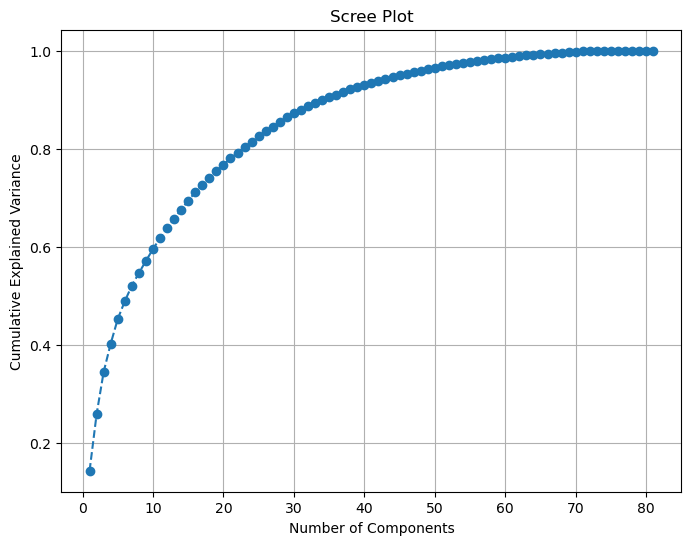

In [54]:
# Plot the scree plot to decide how many components to keep
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_arr_min_max) + 1), 
                      cumulative_variance_arr_min_max, 
                      marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [55]:
## Re-apply PCA to the data while selecting for number of components to retain.
# Apply PCA with a specific number of components
num_components = 50
pca_min_max = PCA(n_components=num_components) 
pca_result_arr_min_max = pca_min_max.fit_transform(df_process_min_max)
# Convert PCA result to DataFrame
pca_result_df_min_max = pd.DataFrame(data=pca_result_arr_min_max, columns=[f"PC{i+1}" for i in range(pca_result_arr_min_max.shape[1])])
# Explained variance ratio for each principal component
explained_var_ratio_arr_min_max = pca_min_max.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance_arr_min_max = np.cumsum(explained_var_ratio_arr_min_max)



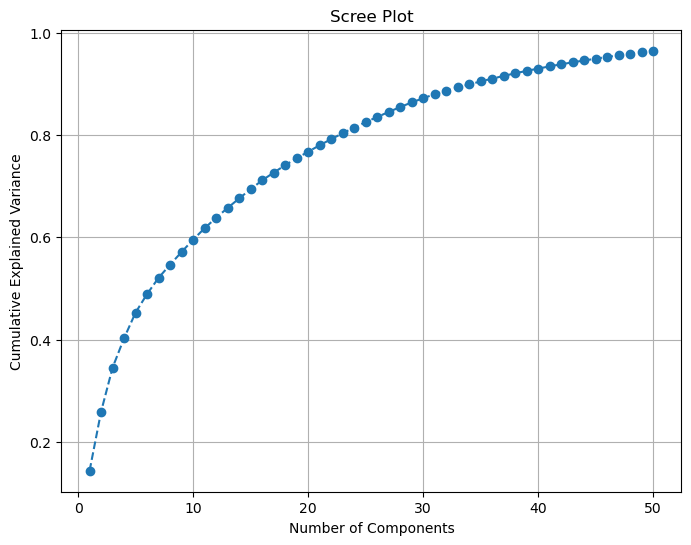

In [56]:
# Plot the scree plot to decide how many components to keep
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_arr_min_max) + 1), 
                      cumulative_variance_arr_min_max, 
                      marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Step 1: Access the first principal component (PC1)
first_pc_min_max = pca_min_max.components_[0]

# Step 2: Create a DataFrame linking the weights to feature names
weights_df_min_max = pd.DataFrame({'Feature': df_process_min_max.columns, 'Weight': first_pc_min_max})

# Step 3: Sort the DataFrame by the absolute values of the weights
weights_df_min_max['Absolute_Weight'] = abs(weights_df_min_max['Weight'])
weights_df_min_max_sorted = weights_df_min_max.sort_values(by='Absolute_Weight', ascending=False)

# Analysis: Print the linked values, sorted by weight
print(weights_df_min_max_sorted)

                        Feature    Weight  Absolute_Weight
2             FINANZ_MINIMALIST -0.238408         0.238408
76     CAMEO_INTL_2015_FAMILY_1  0.231056         0.231056
71      CAMEO_INTL_2015_HOUSE_1  0.224188         0.224188
36                  KBA05_ANTG1 -0.210094         0.210094
3                 FINANZ_SPARER  0.209102         0.209102
53                   PLZ8_ANTG4  0.204786         0.204786
52                   PLZ8_ANTG3  0.189605         0.189605
40                    KBA05_GBZ -0.185888         0.185888
28           HH_EINKOMMEN_SCORE  0.180532         0.180532
46                   MOBI_REGIO -0.180199         0.180199
70  PRAEGENDE_JUGENDJAHRE_GEN_6  0.179415         0.179415
42                     EWDICHTE  0.162115         0.162115
0          ALTERSKATEGORIE_GROB -0.159150         0.159150
4              FINANZ_VORSORGER -0.158563         0.158563
8              GREEN_AVANTGARDE -0.152023         0.152023
64   PRAEGENDE_JUGENDJAHRE_MOVE  0.152023         0.1520

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Step 1: Access the first principal component (PC1)
first_pc_min_max = pca_min_max.components_[1]

# Step 2: Create a DataFrame linking the weights to feature names
weights_df_min_max = pd.DataFrame({'Feature': df_process_min_max.columns, 'Weight': first_pc_min_max})

# Step 3: Sort the DataFrame by the absolute values of the weights
weights_df_min_max['Absolute_Weight'] = abs(weights_df_min_max['Weight'])
weights_df_min_max_sorted = weights_df_min_max.sort_values(by='Absolute_Weight', ascending=False)

# Analysis: Print the linked values, sorted by weight
print(weights_df_min_max_sorted)


                        Feature    Weight  Absolute_Weight
70  PRAEGENDE_JUGENDJAHRE_GEN_6  0.267891         0.267891
3                 FINANZ_SPARER  0.227301         0.227301
0          ALTERSKATEGORIE_GROB -0.224588         0.224588
6         FINANZ_UNAUFFAELLIGER  0.224121         0.224121
4              FINANZ_VORSORGER -0.215592         0.215592
5                FINANZ_ANLEGER  0.209057         0.209057
13                    SEMIO_REL  0.202710         0.202710
10               RETOURTYP_BK_S -0.179732         0.179732
23                SEMIO_PFLICHT  0.178768         0.178768
18                   SEMIO_KULT  0.177167         0.177167
17                    SEMIO_ERL -0.176455         0.176455
24                  SEMIO_TRADV  0.174789         0.174789
16                   SEMIO_LUST -0.164338         0.164338
47            ONLINE_AFFINITAET  0.158413         0.158413
7              FINANZ_HAUSBAUER -0.146001         0.146001
71      CAMEO_INTL_2015_HOUSE_1 -0.141694         0.1416

In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
first_pc_min_max = pca_min_max.components_[1]

# Step 2: Create a DataFrame linking the weights to feature names
weights_df_min_max = pd.DataFrame({'Feature': df_process_min_max.columns, 'Weight': first_pc_min_max})

# Step 3: Sort the DataFrame by the absolute values of the weights
weights_df_min_max['Absolute_Weight'] = abs(weights_df_min_max['Weight'])
weights_df_min_max_sorted = weights_df_min_max.sort_values(by='Absolute_Weight', ascending=False)

# Analysis: Print the linked values, sorted by weight
print(weights_df_min_max_sorted)


                        Feature    Weight  Absolute_Weight
70  PRAEGENDE_JUGENDJAHRE_GEN_6  0.267891         0.267891
3                 FINANZ_SPARER  0.227301         0.227301
0          ALTERSKATEGORIE_GROB -0.224588         0.224588
6         FINANZ_UNAUFFAELLIGER  0.224121         0.224121
4              FINANZ_VORSORGER -0.215592         0.215592
5                FINANZ_ANLEGER  0.209057         0.209057
13                    SEMIO_REL  0.202710         0.202710
10               RETOURTYP_BK_S -0.179732         0.179732
23                SEMIO_PFLICHT  0.178768         0.178768
18                   SEMIO_KULT  0.177167         0.177167
17                    SEMIO_ERL -0.176455         0.176455
24                  SEMIO_TRADV  0.174789         0.174789
16                   SEMIO_LUST -0.164338         0.164338
47            ONLINE_AFFINITAET  0.158413         0.158413
7              FINANZ_HAUSBAUER -0.146001         0.146001
71      CAMEO_INTL_2015_HOUSE_1 -0.141694         0.1416

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read("

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.